In [1]:
fname = 'data/pax-2017-08-03_03_12d_1nM_comparison.hdf5'

In [2]:
from pathlib import Path
fname = Path(fname)
assert fname.is_file(), 'File not found.'

mlabel = '_'.join(fname.stem.replace('pax-', '').replace('alex-', '').split('_')[:3])
mlabel

'2017-08-03_03_12d'

In [3]:
!date

Thu Oct  5 16:10:42 PDT 2017


# Imports

In [4]:
import os
from pathlib import Path
import numpy as np
from IPython.display import display, HTML, Math
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
%matplotlib inline
import matplotlib.pyplot as plt
from heatmap import heatmap48, spotsh, spotsv
import pybroom as br

/home/anto/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [5]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [6]:
sns = init_notebook(apionly=True)

In [7]:
plt.rcParams['font.size'] = 14

In [8]:
%config InlineBackend.figure_format = 'retina'

In [9]:
# Instead of importing, "load" some utility functions using `%run -i`.
# This gives these functions access to variables defined in the notebok (e.g. mlabel).
# Defines: savefig, save_name, info_html, cal_phrate, make_df_spots, make_df_bursts
#          cal_phrate_alex, make_df_bursts_alex
%run -i utils.py 

In [10]:
plot_timetraces = False
skip_ch = (12, 13)

In [11]:
save_figures = True
savefigdir = 'figures'
highres = True

# Multispot

In [12]:
d = loader.photon_hdf5(str(fname), ondisk=True)

In [13]:
info_html(d)

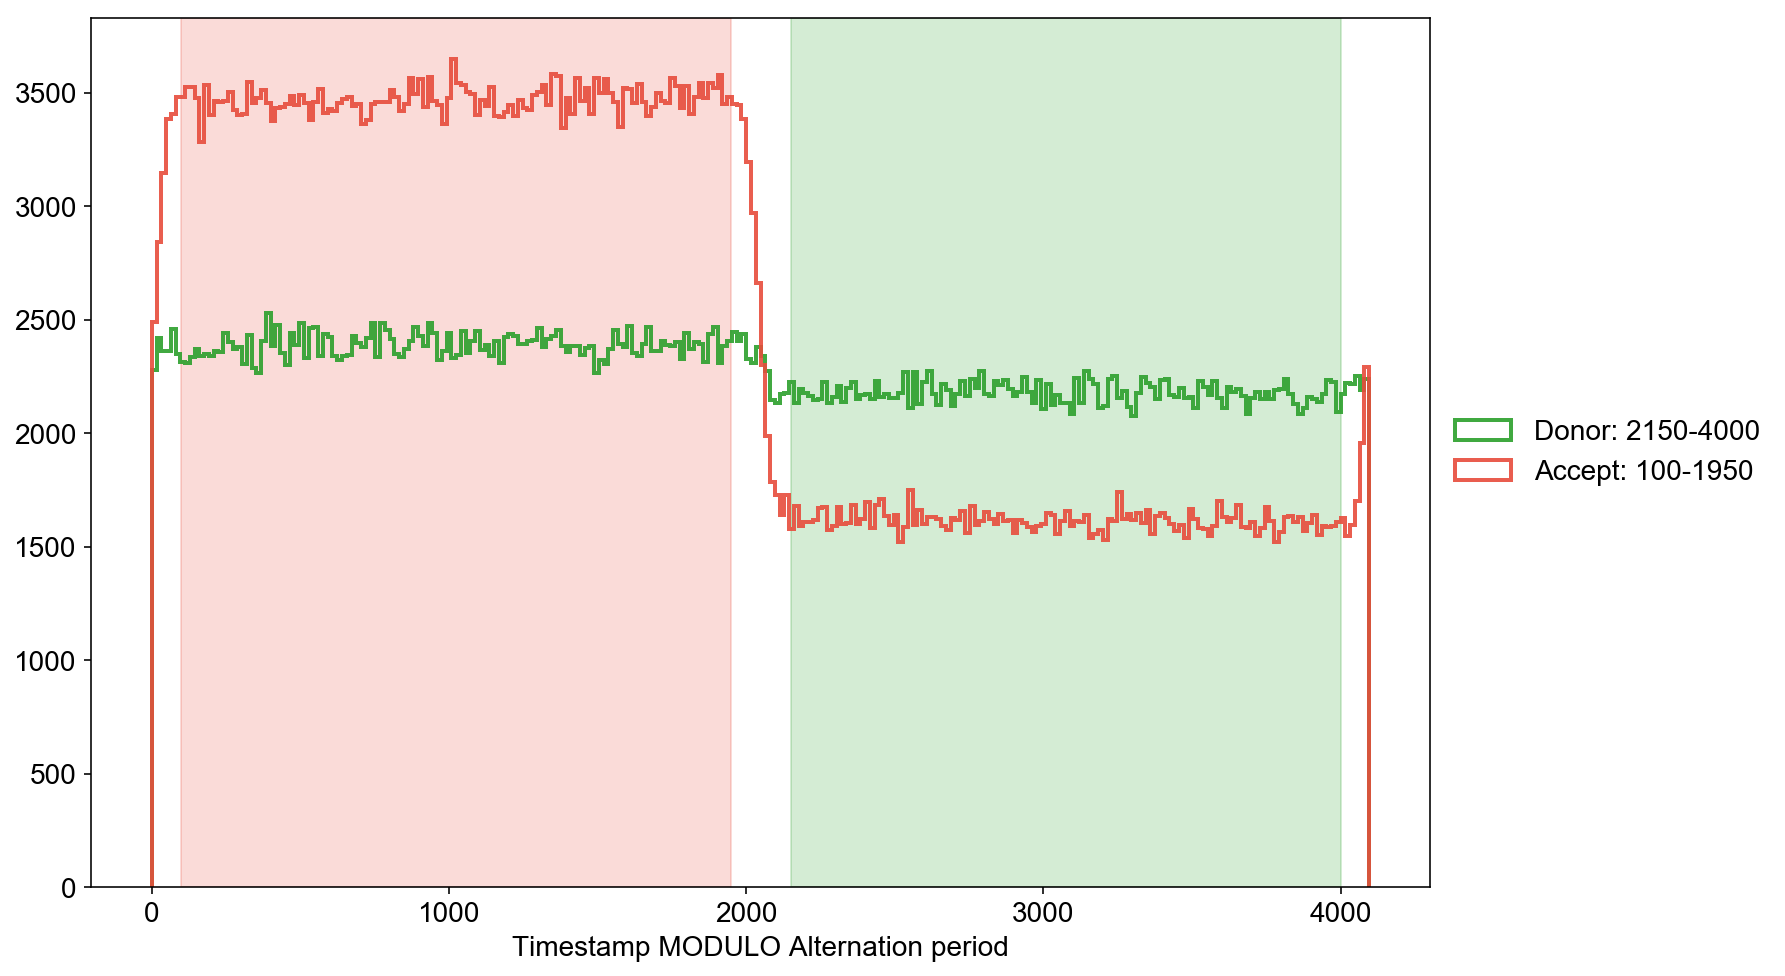

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
bpl.plot_alternation_hist_usalex(d, ax=ax, bins=np.arange(0, 4097, 16))

In [15]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    68,893,535
#  D  photons in D+A excitation periods:   27,365,676
#  A  photons in D+A excitation periods:   41,527,859
# D+A photons in  D  excitation period:    27,255,233
# D+A photons in  A  excitation period:    41,638,302



## Timetraces

In [16]:
if plot_timetraces:
    num_time_points = 5
    kws = dict(figsize=(24, 8), xrotation=45, hspace=0, wspace=0)
    
    # Timepoints equally distributed along the measurement
    time_points = np.round(np.linspace(d.time_min+1, d.time_max-2, num=num_time_points))

    for i in time_points:
        dplot(d, timetrace, tmin=i, tmax=i+1, **kws);
        plt.ylim(-40, 40)
        savefig("%s_timetrace_t=%d-%d" % (mlabel, i, i+1))

## Background

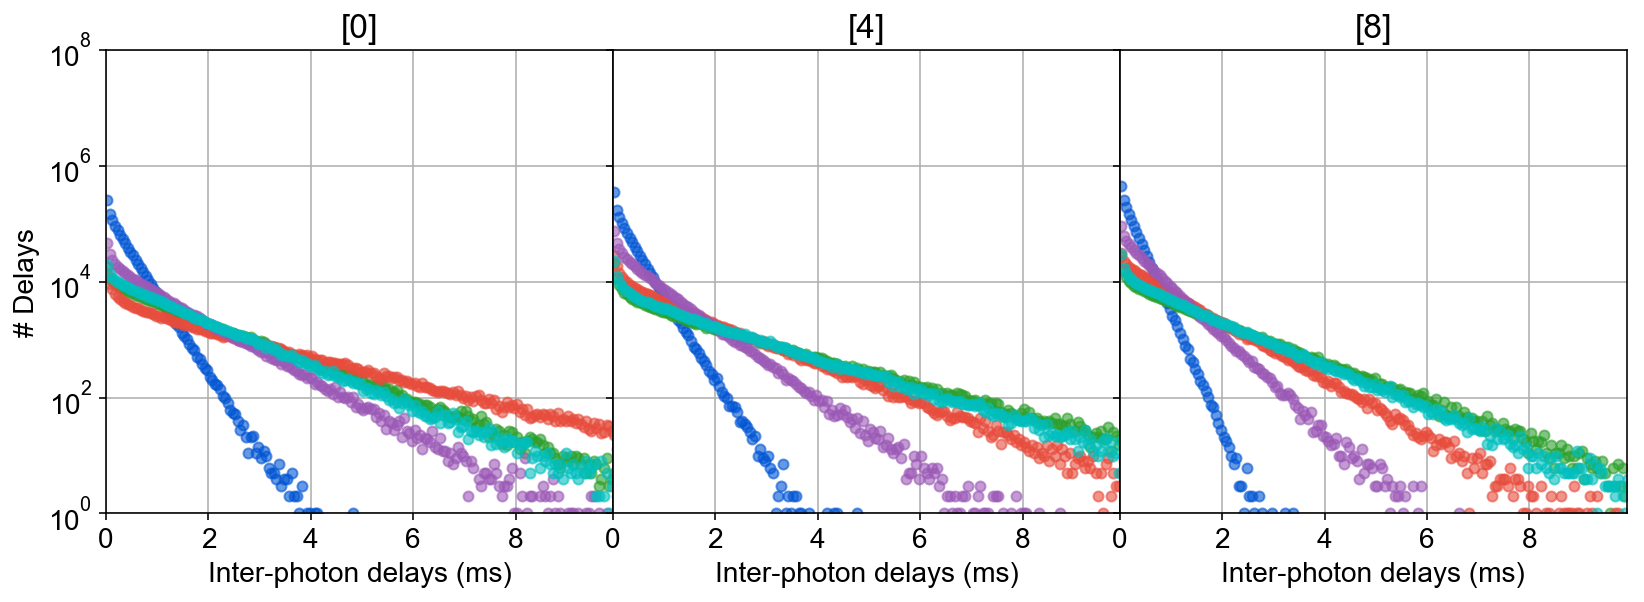

In [17]:
dplot(d, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True);
plt.xlim(50e-6, 9.9);
plt.ylim(1, 1e8);

In [18]:
d.calc_bg_cache(bg.exp_fit, time_s=5, tail_min_us='auto', F_bg=1.7, fit_allph=False)

 * Loading BG rates from cache ... 
 - Loading bakground data:  [DONE]


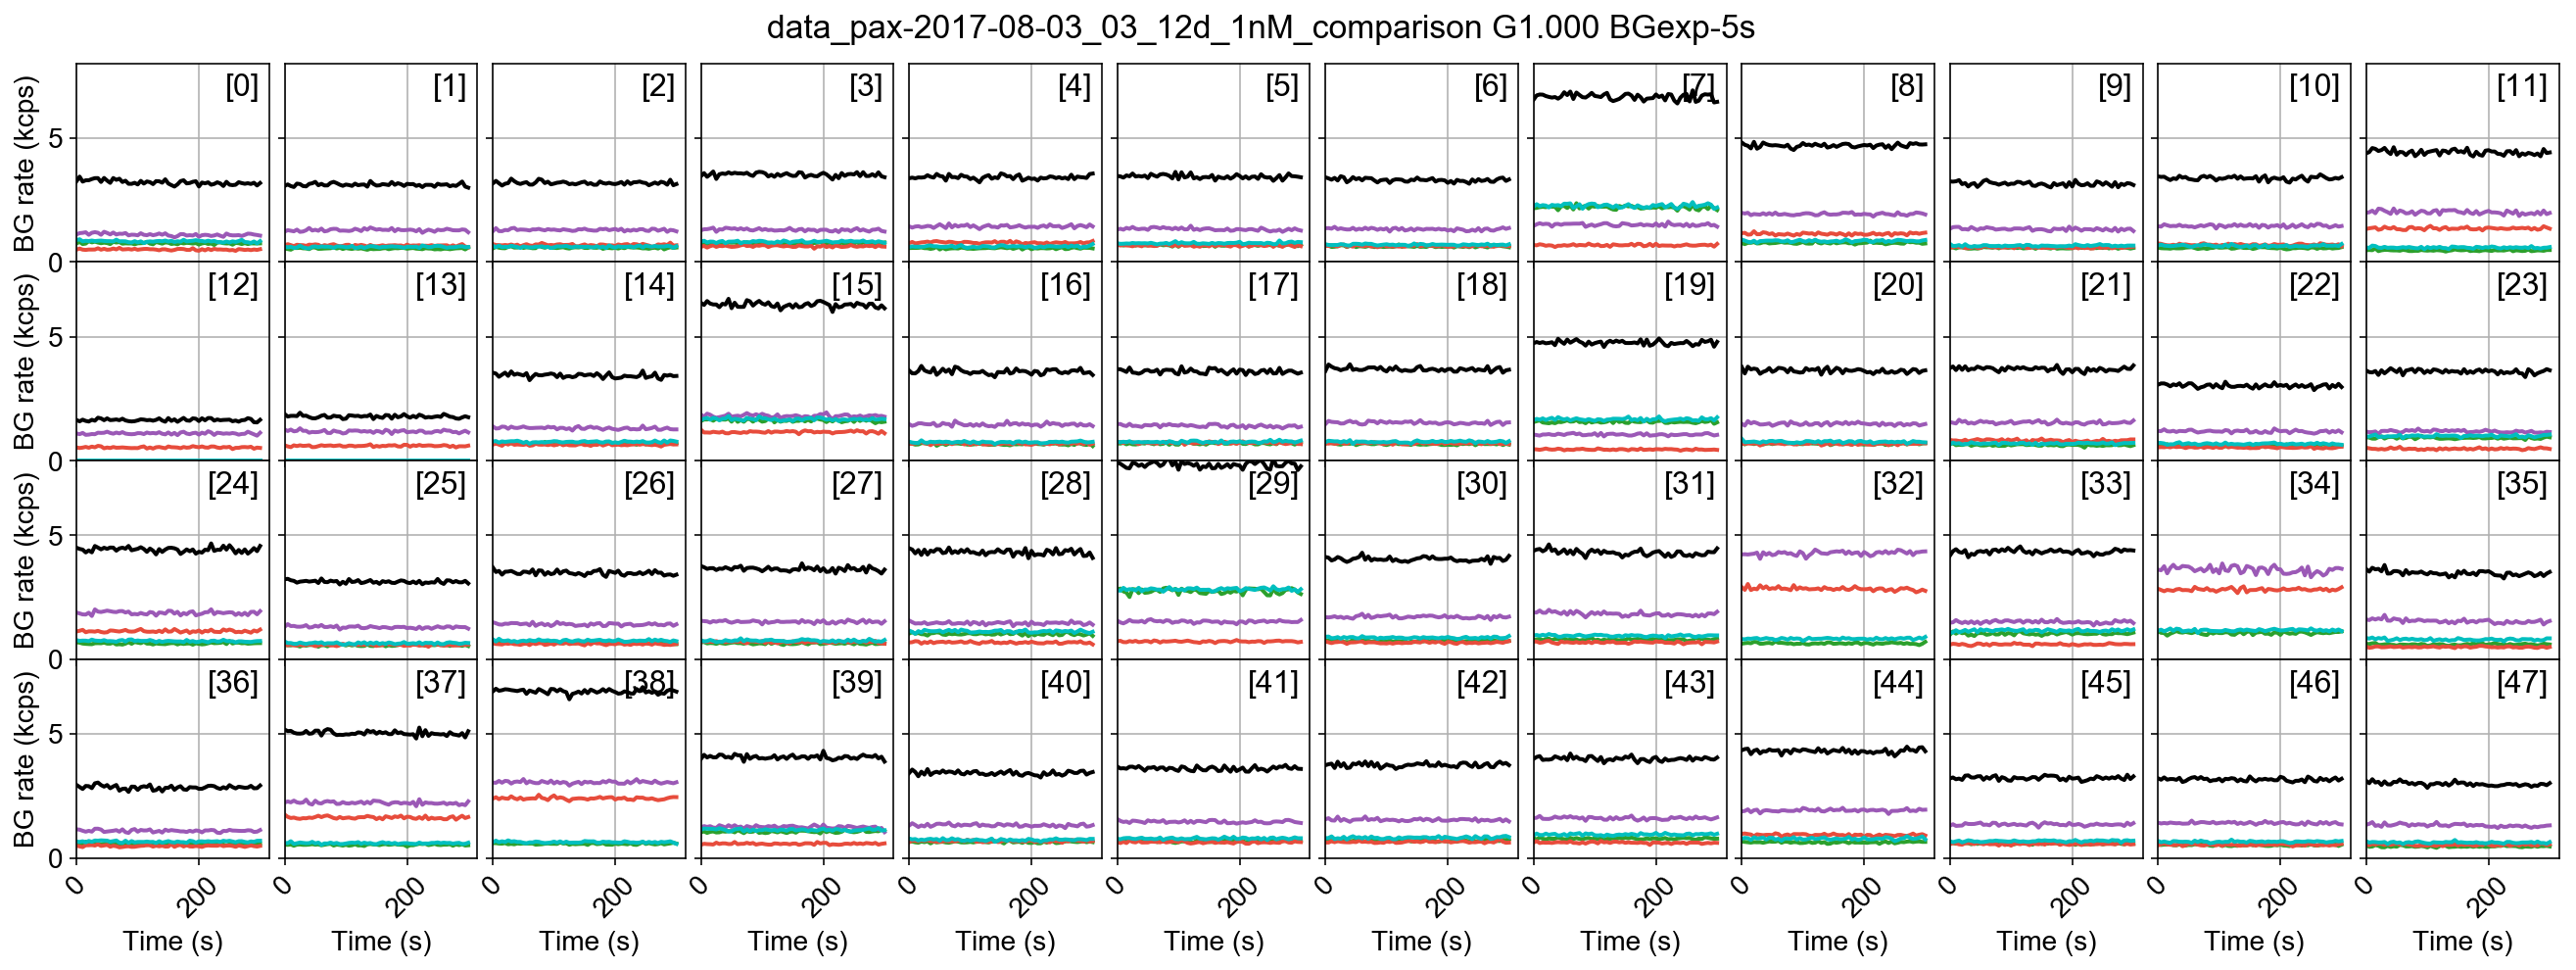

In [19]:
ax = dplot(d, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45);
plt.xlim(0)
plt.ylim(0, 8);

In [20]:
bg_AexDem = d.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem = d.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem = d.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem = d.bg_from(Ph_sel(Dex='Aem'))

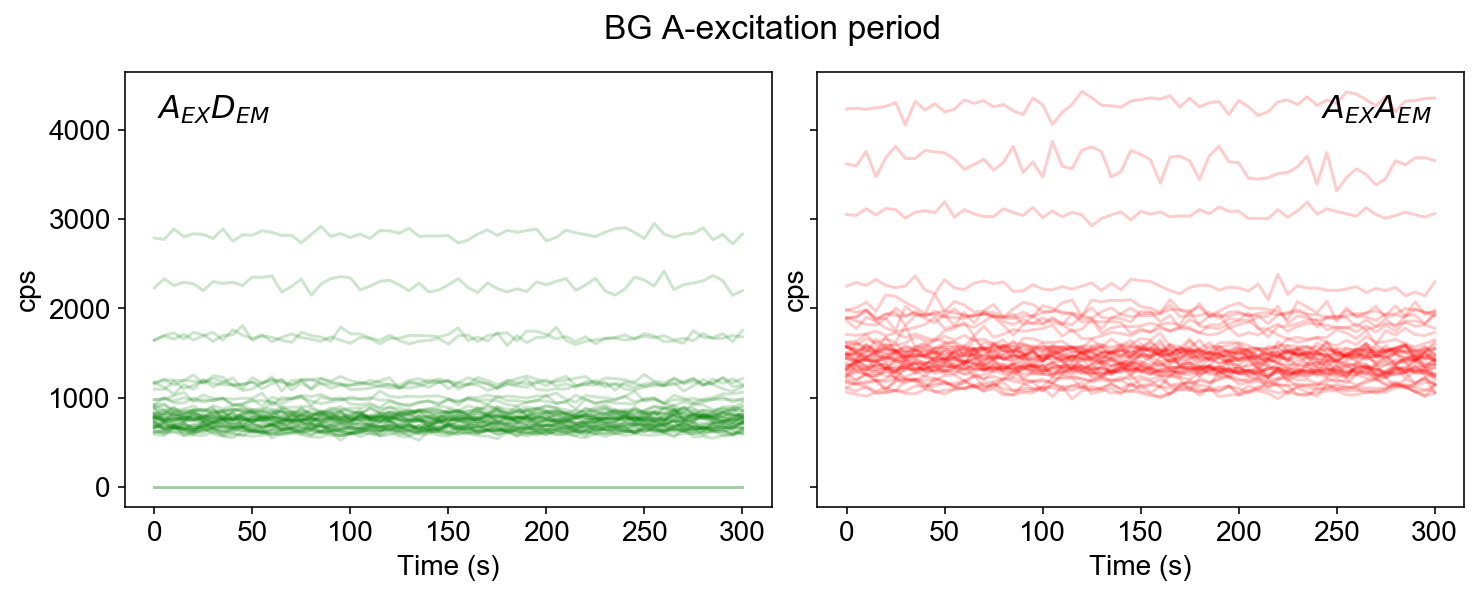

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG A-excitation period")
t = np.arange(len(bg_AexDem[0])) * 5
ax[0].plot(t, np.array(bg_AexDem).T, color='g', alpha=0.2);
ax[1].plot(t, np.array(bg_AexAem).T, color='r', alpha=0.2);
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes);

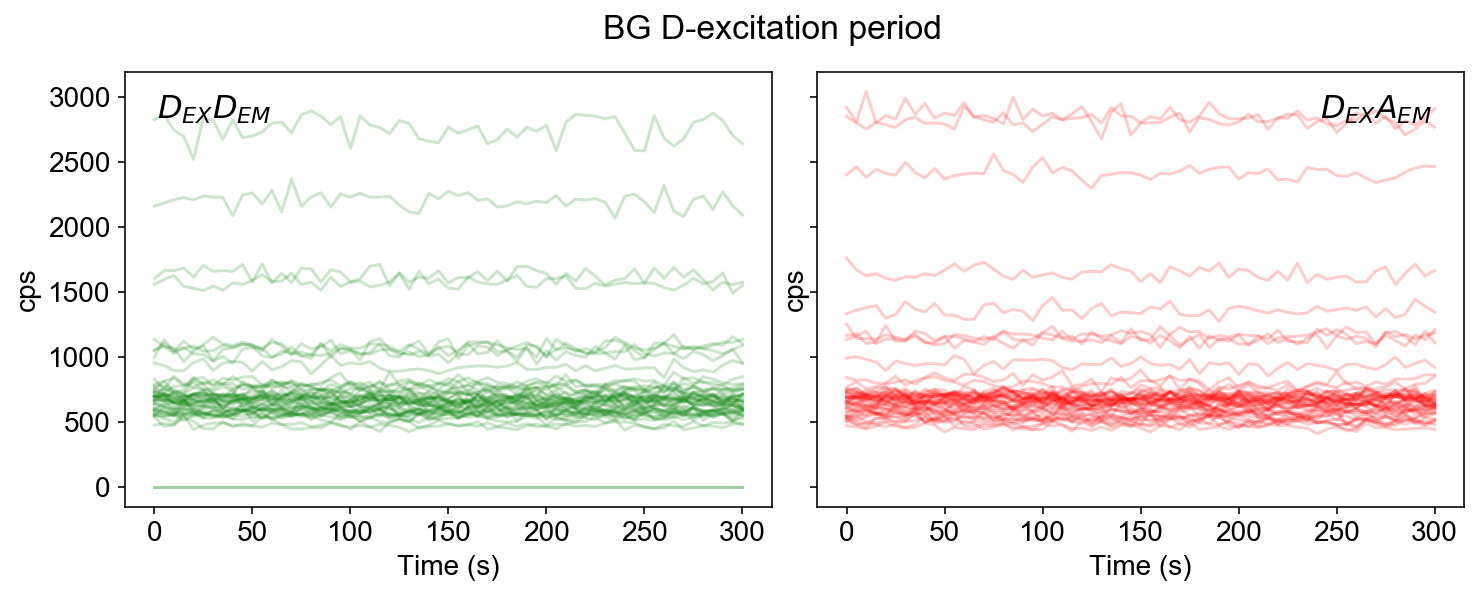

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG D-excitation period")
t = np.arange(len(bg_DexDem[0])) * 5
ax[0].plot(t, np.array(bg_DexDem).T, color='g', alpha=0.2);
ax[1].plot(t, np.array(bg_DexAem).T, color='r', alpha=0.2);
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes);

## Burst search

In [23]:
d.burst_search(min_rate_cps=20e3, pax=True)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


# ALEX

In [24]:
fname_alex = 'data/alex-2017-08-03_007_12d_100pM_comparison_D-190uW_A-80uW.hdf5' 

In [25]:
fname_alex = Path(fname_alex)

In [26]:
mlabel_alex = '_'.join(fname_alex.stem.replace('pax-', '').replace('alex-', '').split('_')[:3])
mlabel_alex

'2017-08-03_007_12d'

In [27]:
assert fname_alex.is_file(), 'File not found.'

In [28]:
dax = loader.photon_hdf5(fname_alex)

In [29]:
info_html(dax)

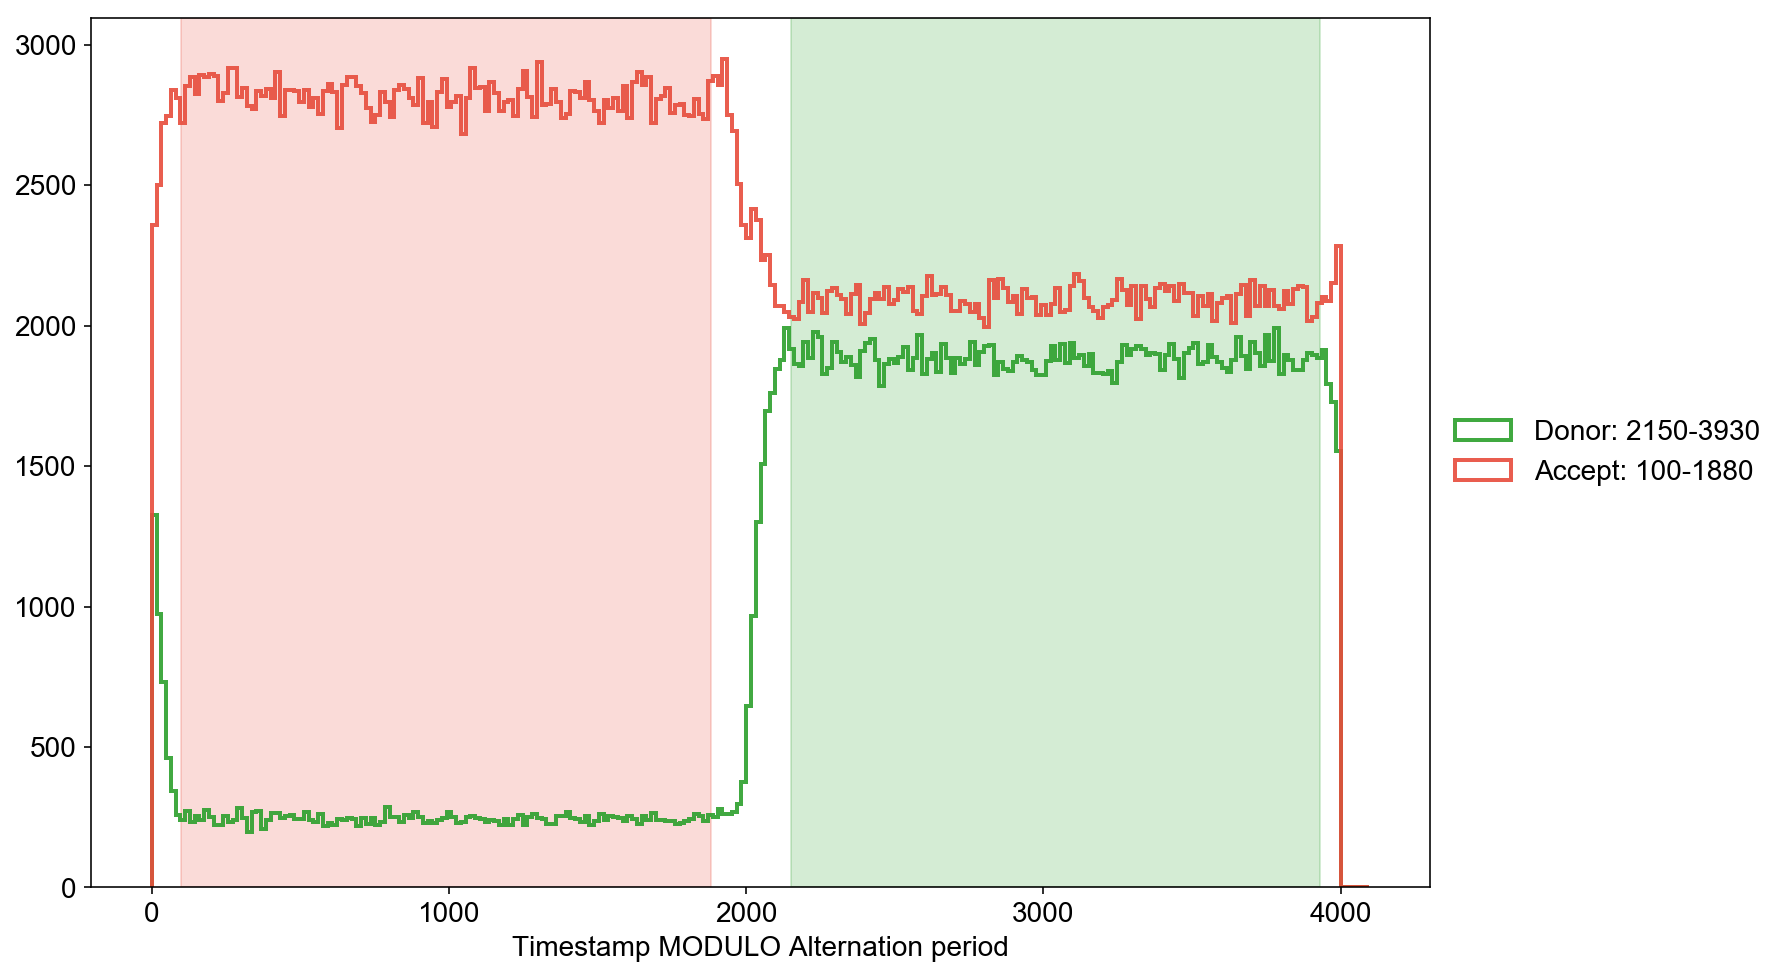

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
bpl.plot_alternation_hist_usalex(dax, ax=ax, bins=np.arange(0, 4097, 16))

In [31]:
loader.alex_apply_period(dax)

# Total photons (after ALEX selection):       782,848
#  D  photons in D+A excitation periods:      236,818
#  A  photons in D+A excitation periods:      546,030
# D+A photons in  D  excitation period:       442,576
# D+A photons in  A  excitation period:       340,272



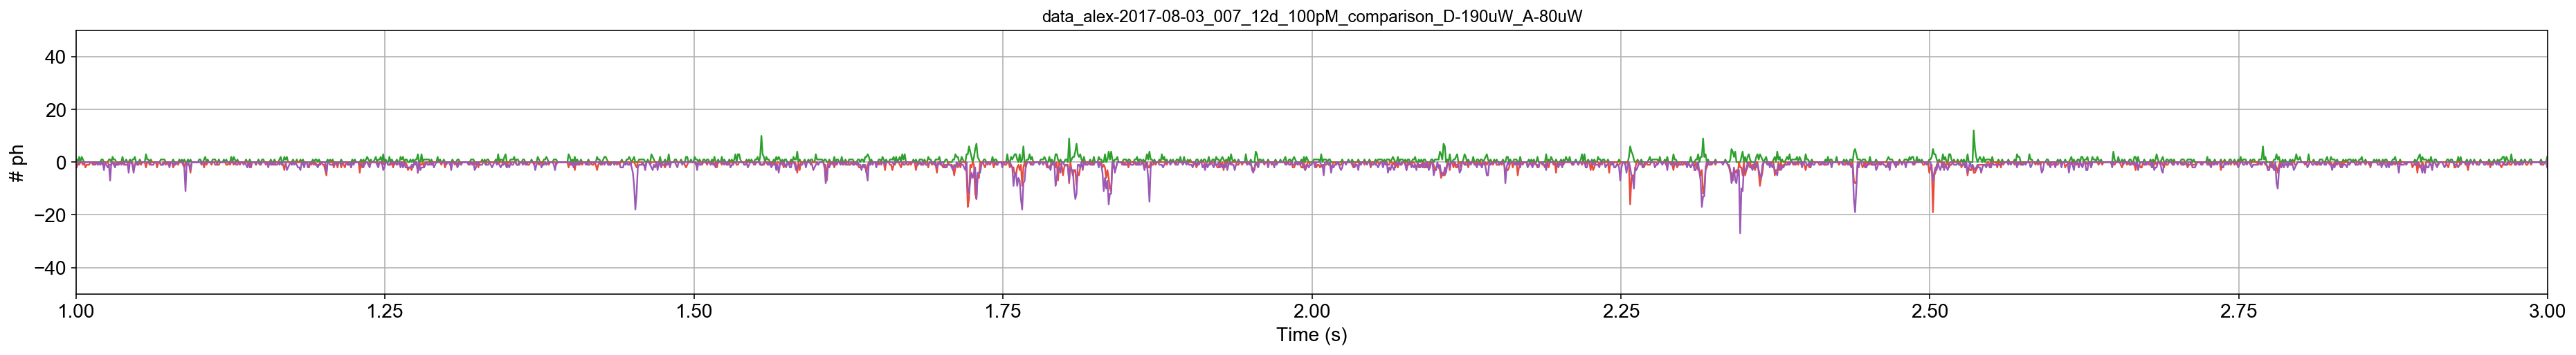

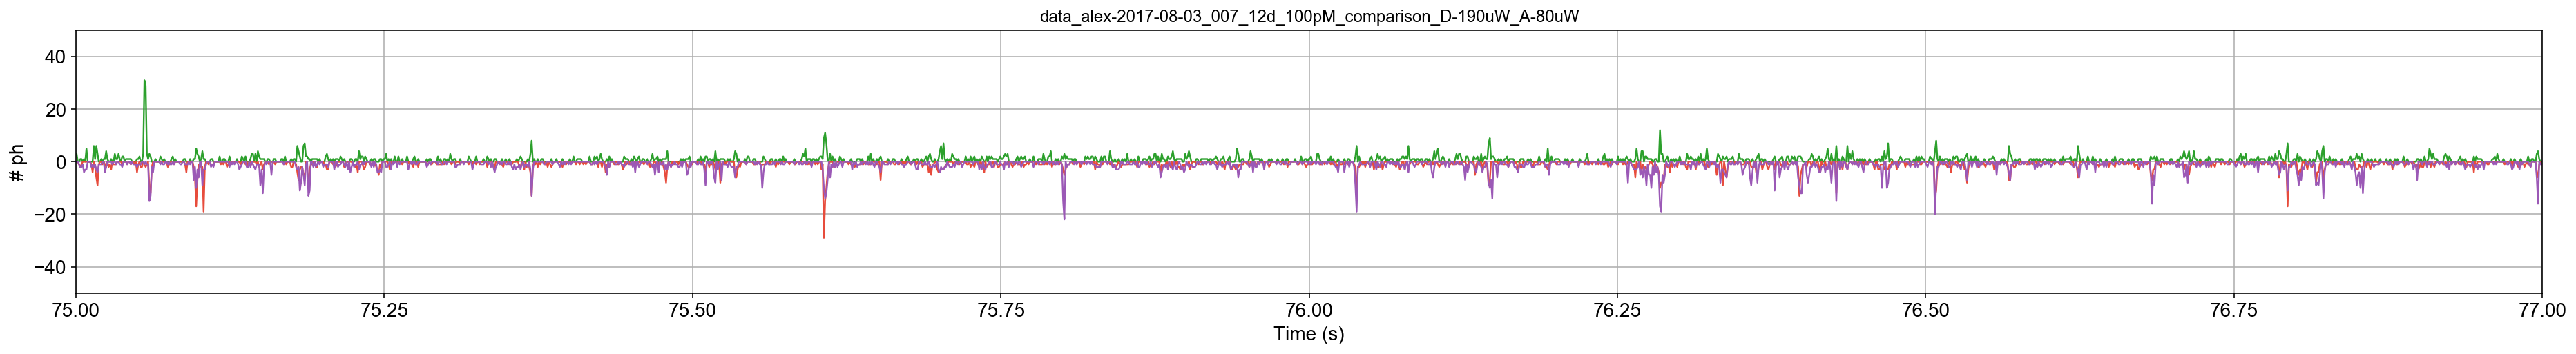

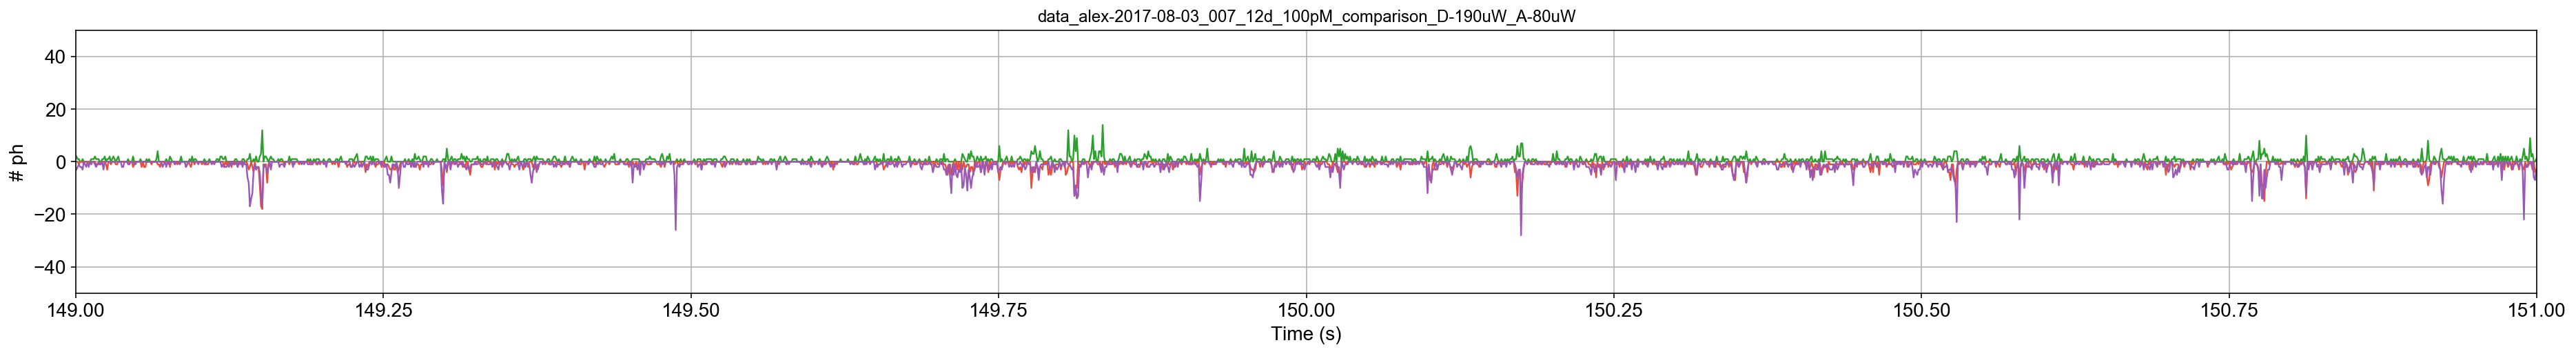

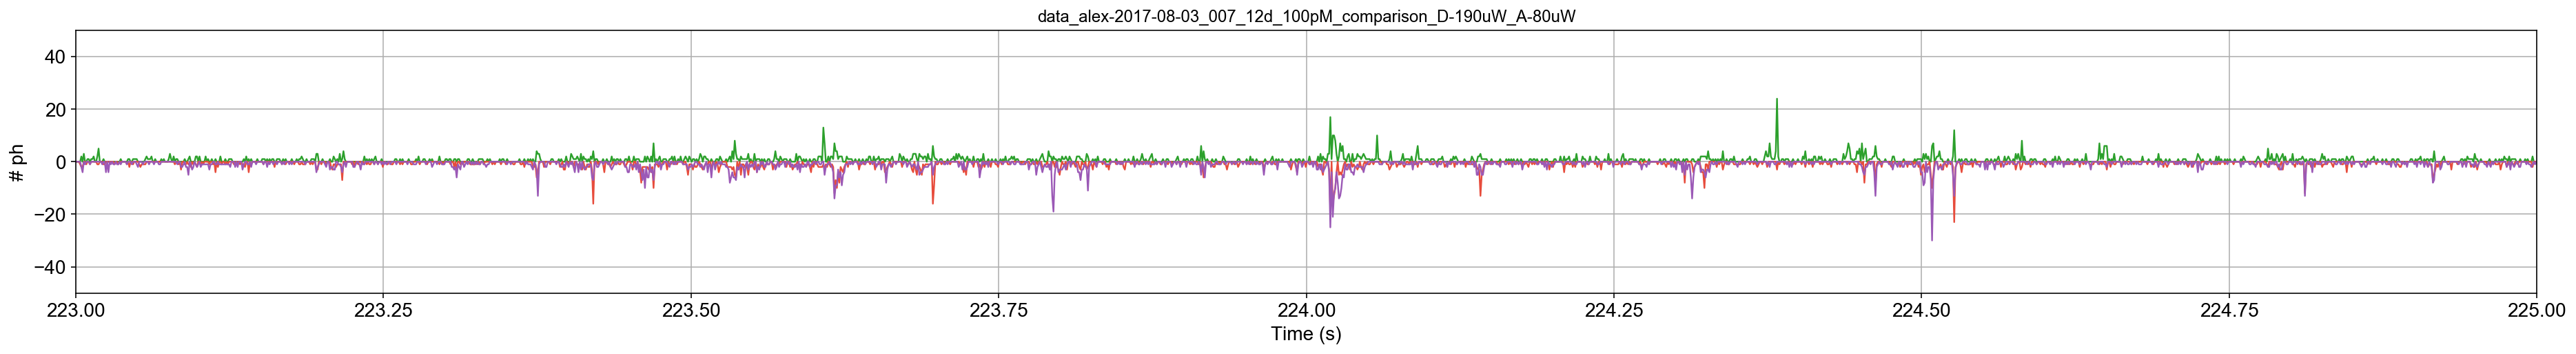

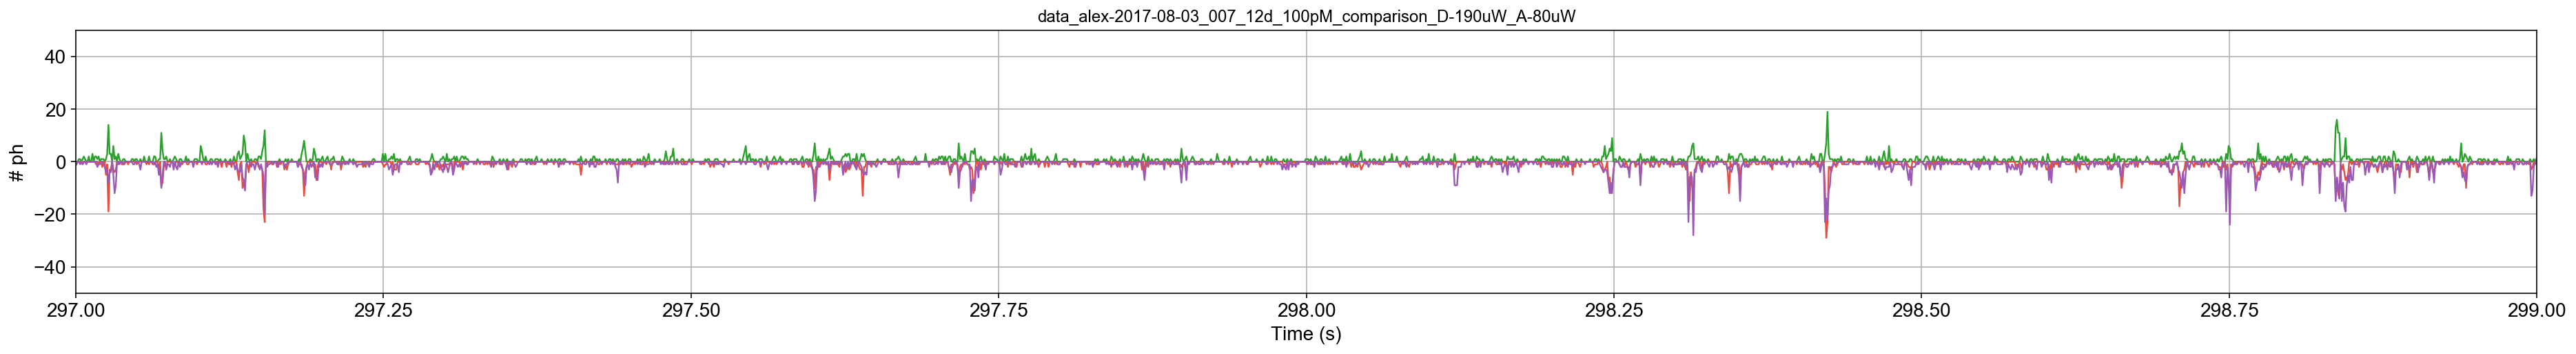

In [32]:
num_time_points = 5
window = 2

# Timepoints equally distributed along the measurement
time_points = np.round(np.linspace(dax.time_min+1, dax.time_max-window-1, num=num_time_points))

for i in time_points:
    dplot(dax, timetrace, tmin=i, tmax=i+window, figsize=(32, 3.5));
    plt.ylim(-50, 50)
    plt.xlim(i, i+window)

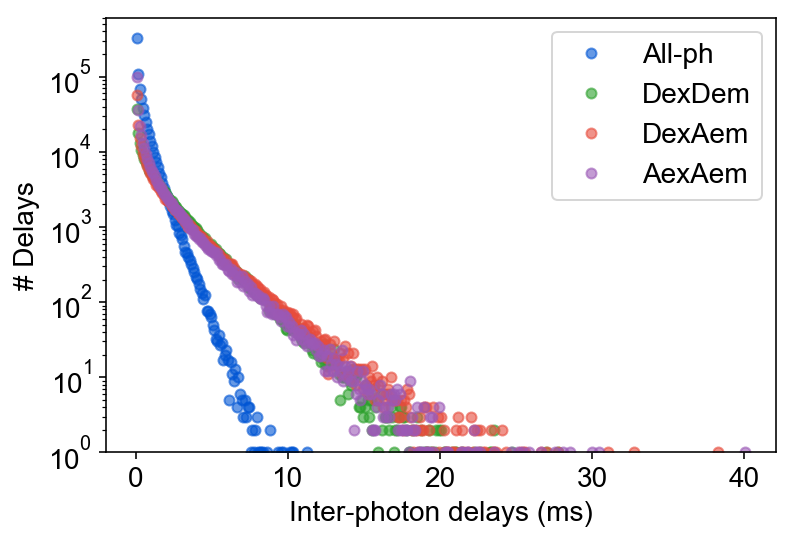

In [33]:
hist_interphoton(dax)

In [34]:
dax.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1, fit_allph=False)

 - Calculating BG rates ... [DONE]


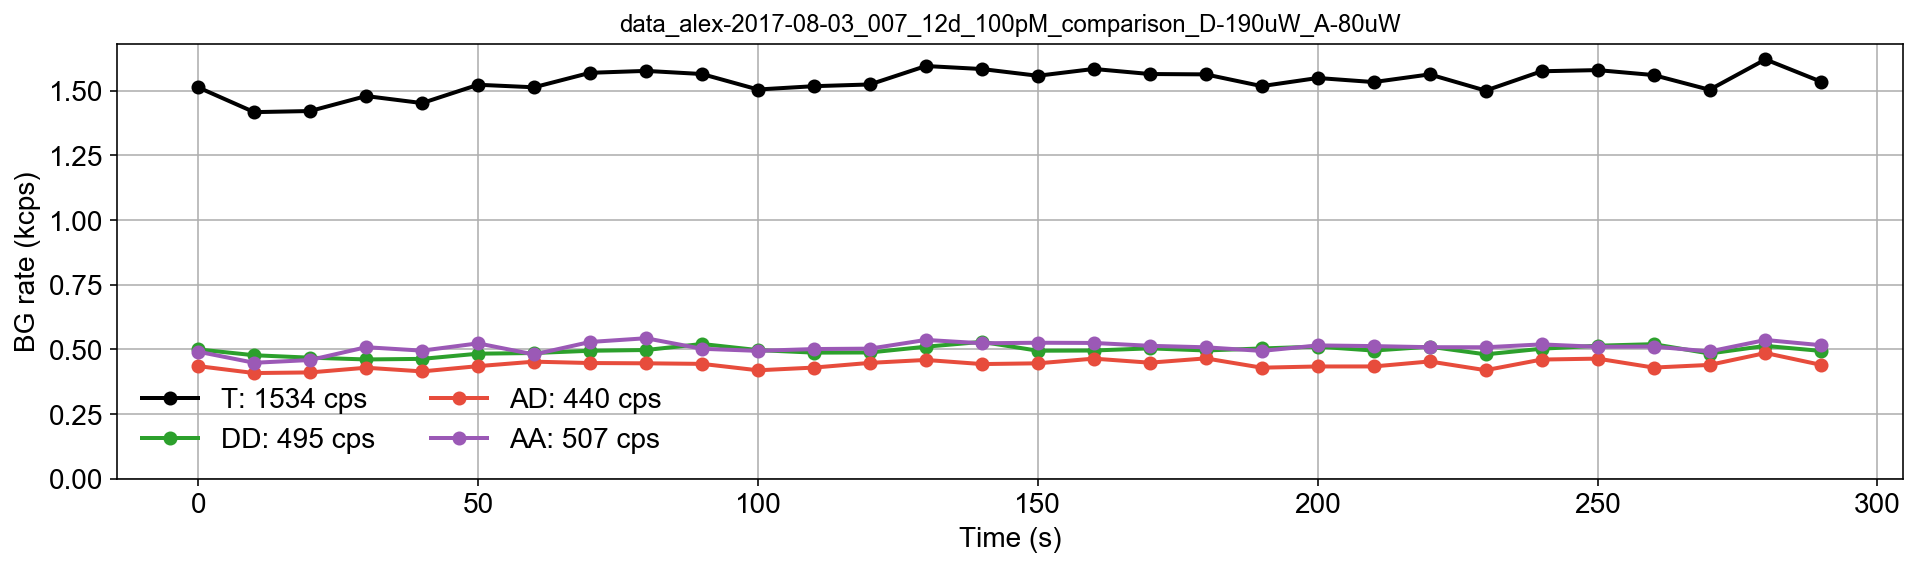

In [35]:
fig, ax = plt.subplots(figsize=(16, 4))
dplot(dax, timetrace_bg, ax=ax)

In [36]:
dax.burst_search(min_rate_cps=20e3)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


# Burst sizes

In [37]:
kws = dict(skip_ch=skip_ch, hspace=0, wspace=0, top=0.96, 
           title_bg=False, title_nbursts=False, title='in')

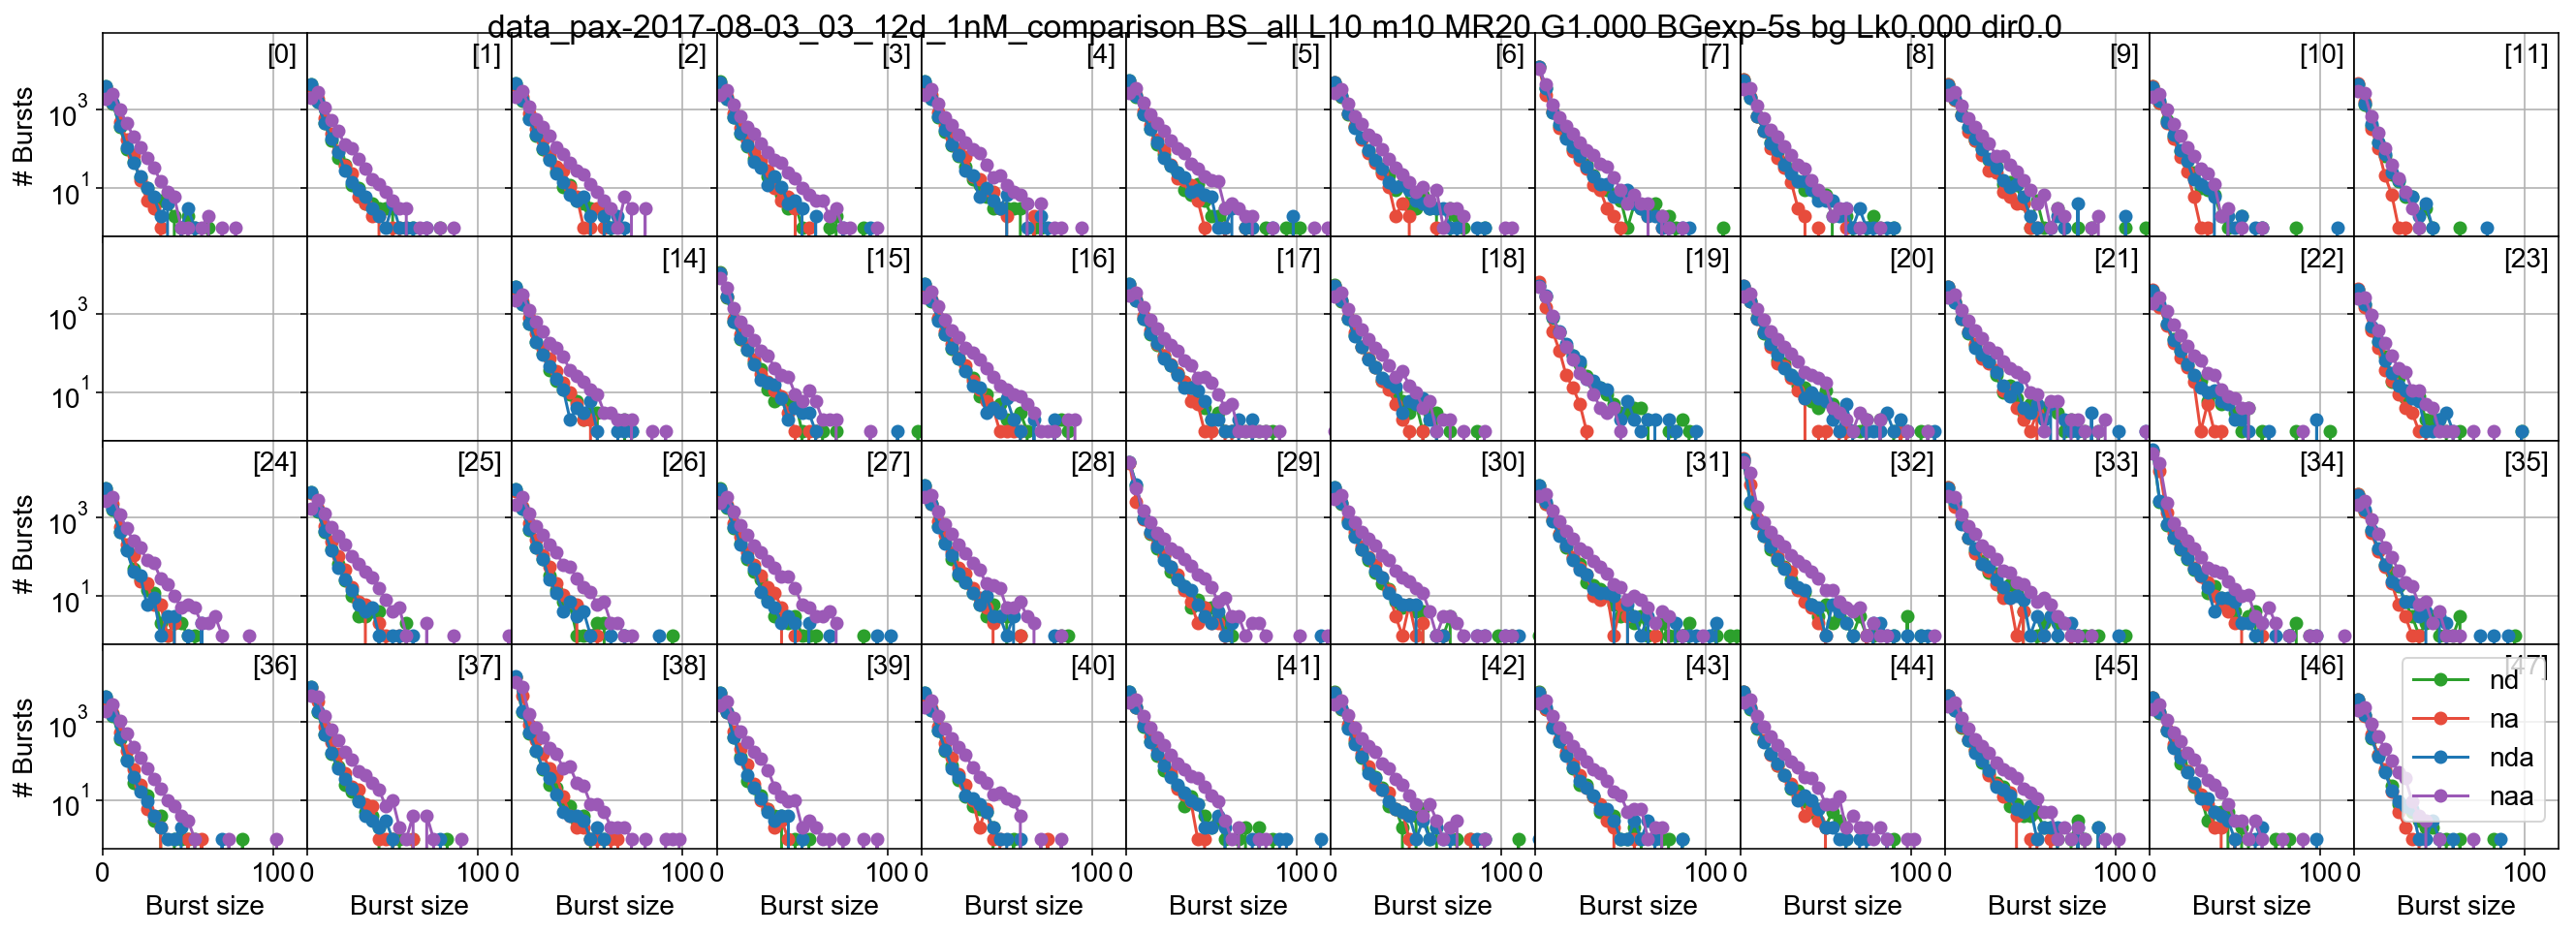

In [38]:
dplot(d, hist_size_all, **kws);
plt.xlim(0, 120)
plt.legend();

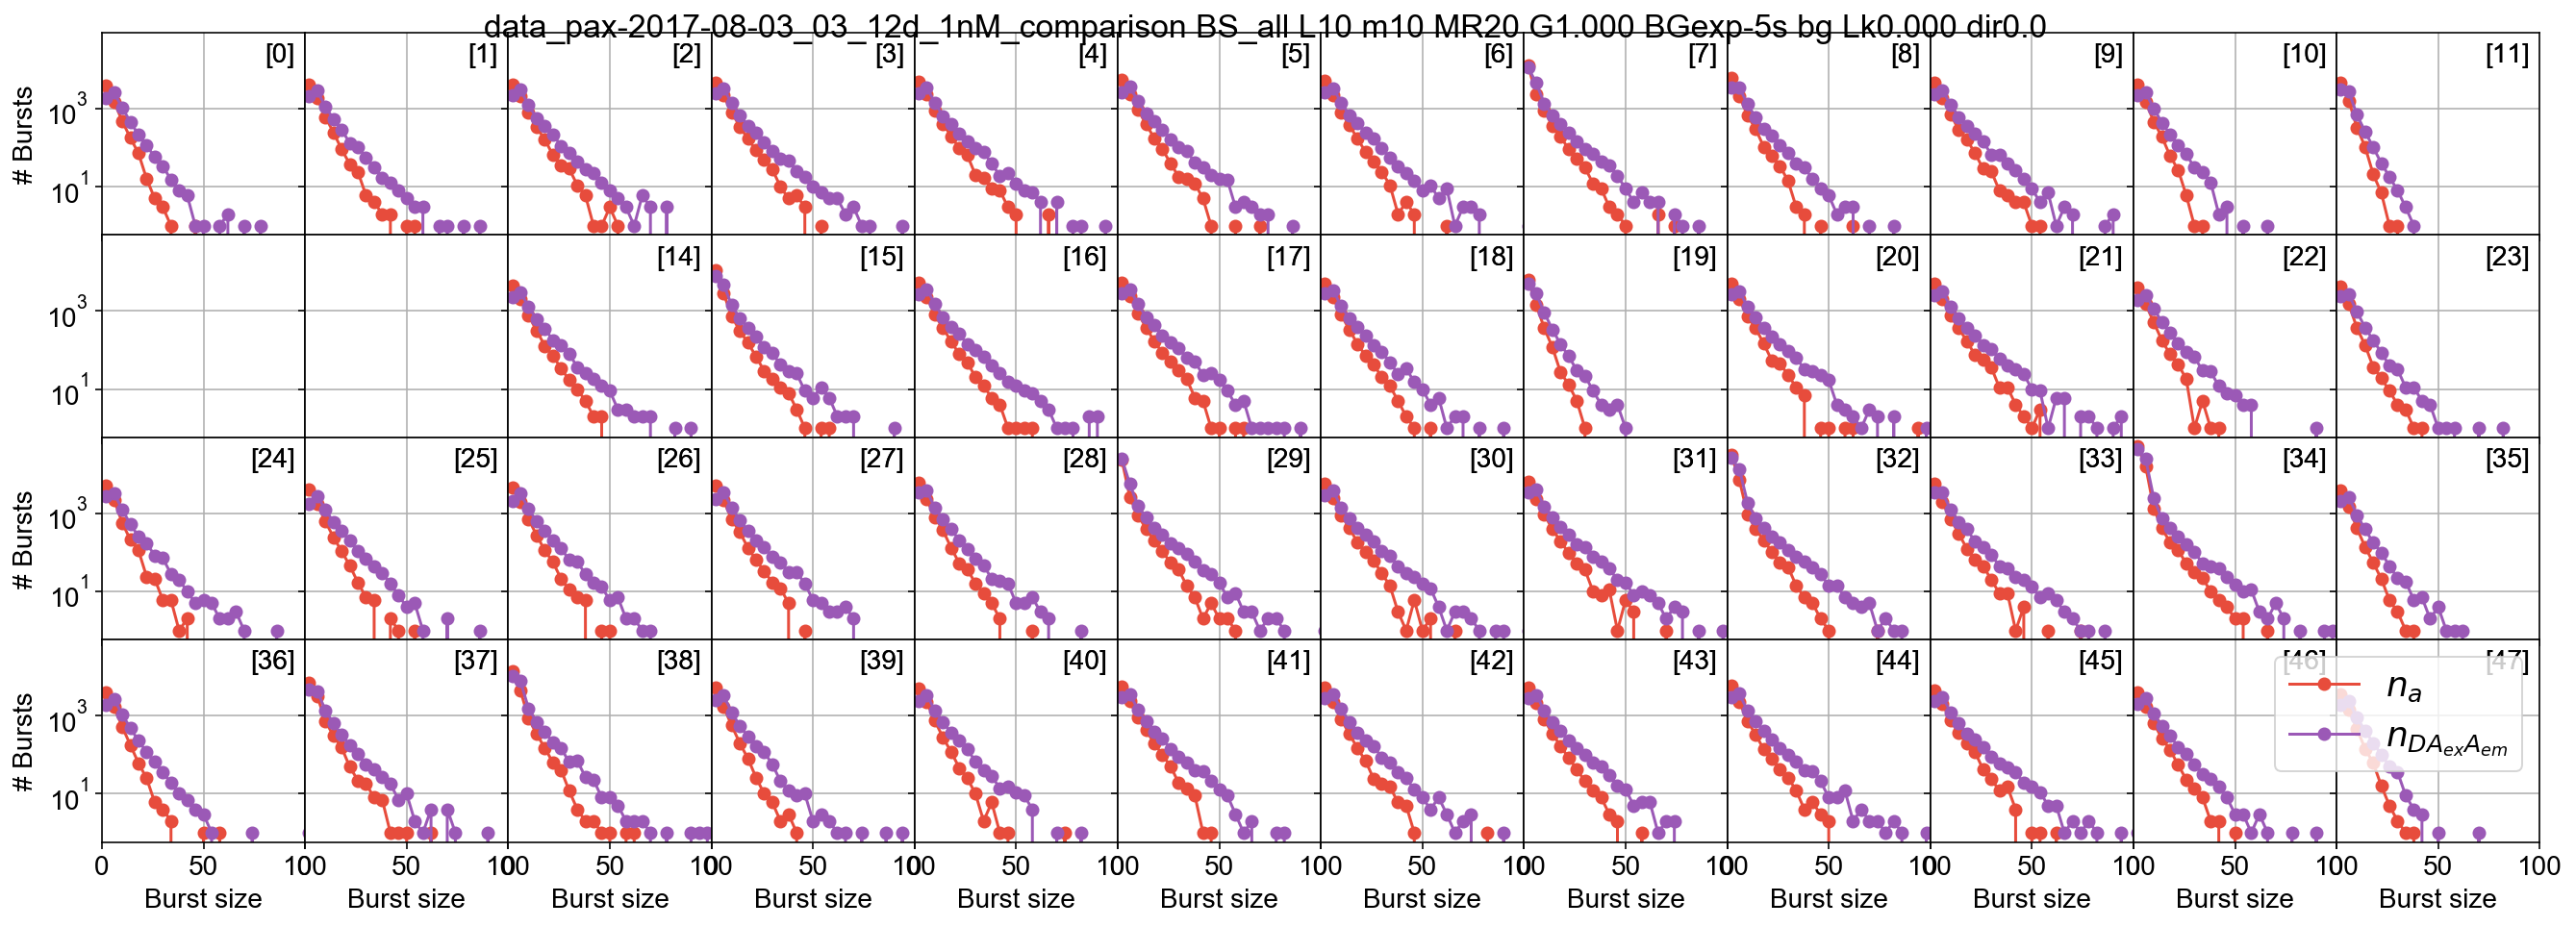

In [39]:
kws.update(title_nbursts=False)
ax = dplot(d, hist_size, which='na', **kws);
dplot(d, hist_size, which='naa', AX=ax, **kws);
plt.xlim(0, 100);
plt.legend(['$n_a$', '$n_{DA_{ex}A_{em}}$'], fontsize=18, loc='upper right')

<IPython.core.display.Math object>

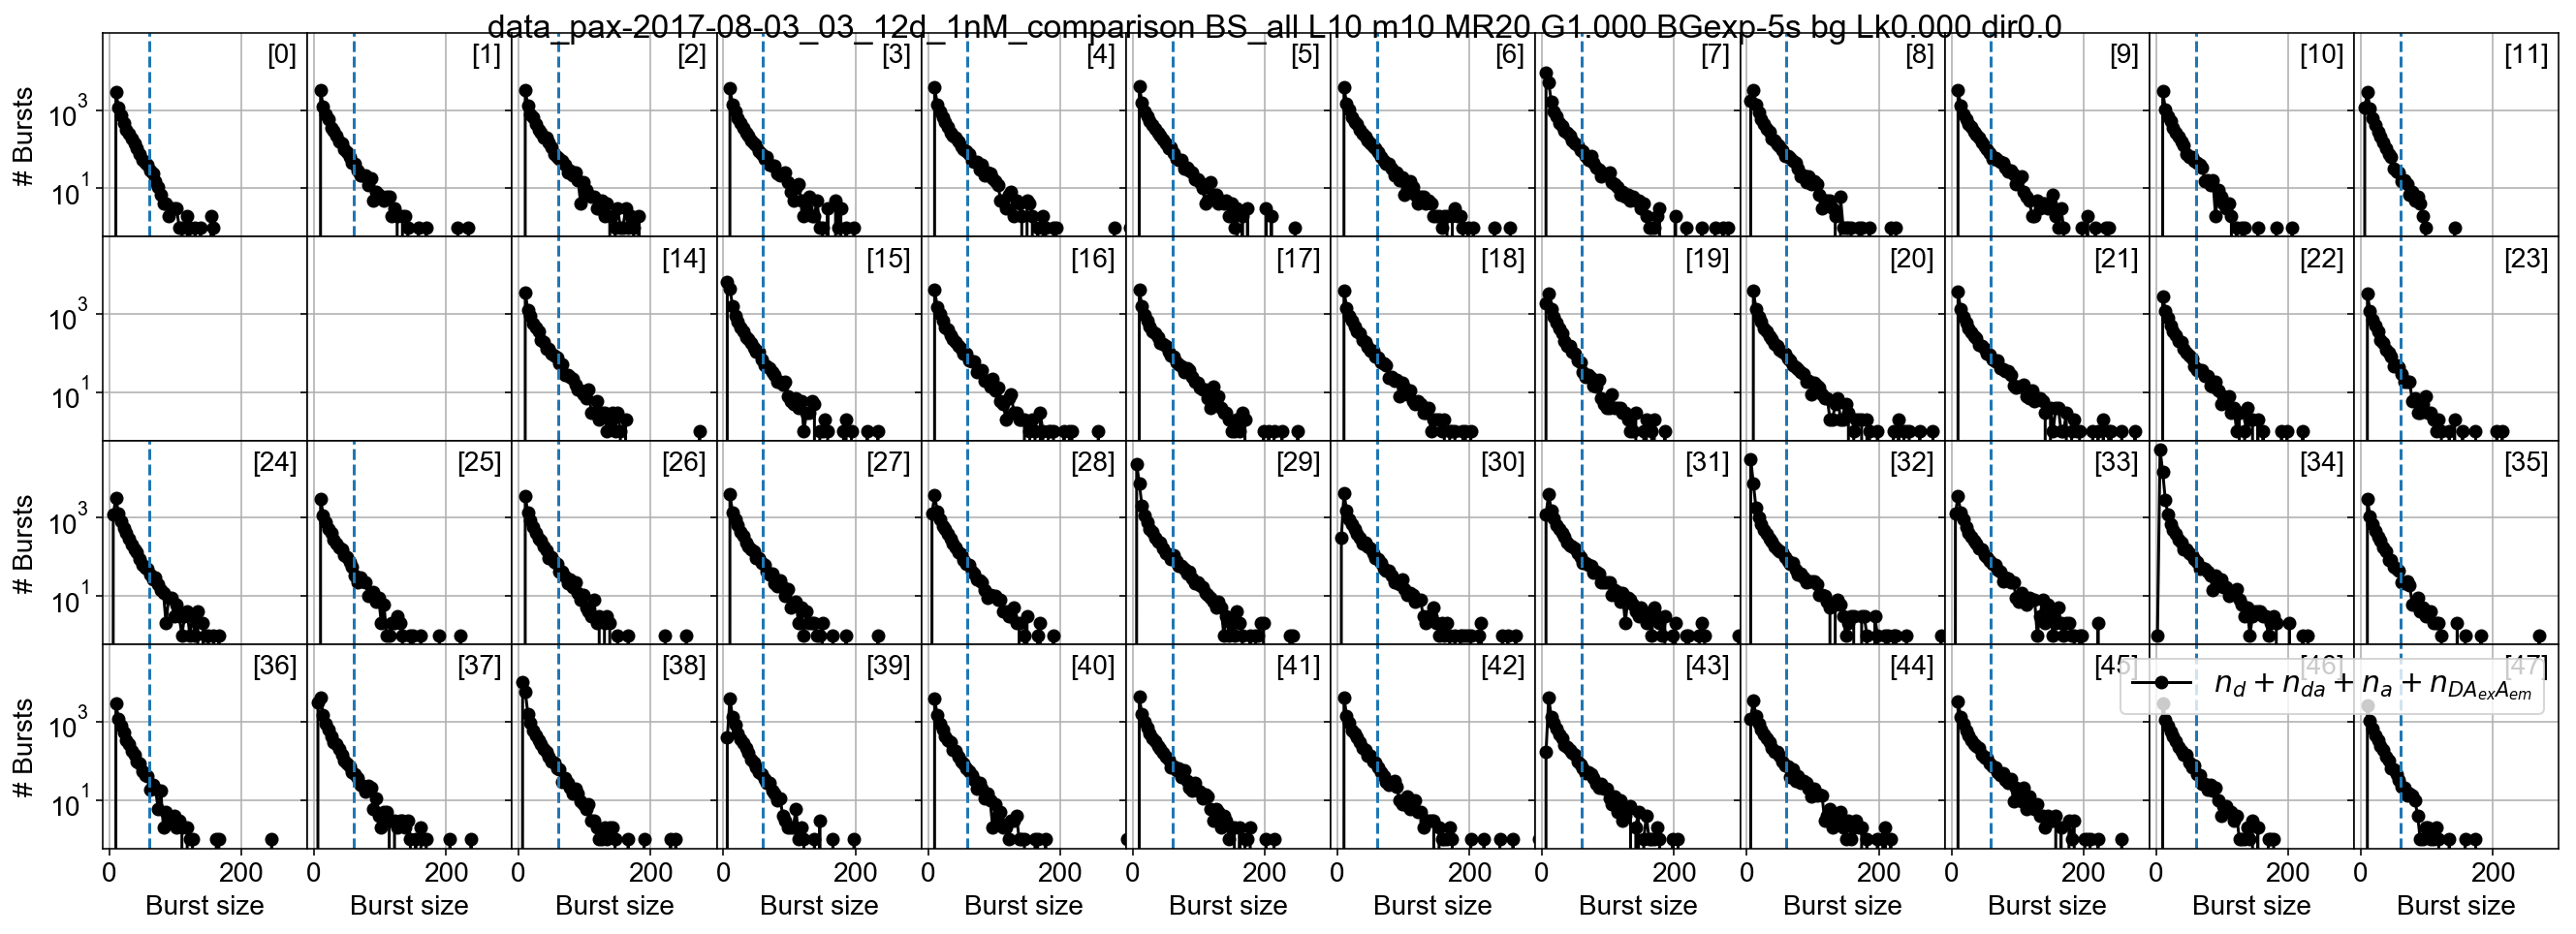

In [40]:
size_th = 60
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='DAem'),
                    na_comp=False, naa_comp=False, naa_aexonly=False)
dplot(d, hist_size, vline=size_th, **size_sel_kws, **kws);
plt.xlim(-10, 300)
plt.legend(fontsize=15, loc='upper right');
Math(d._burst_sizes_pax_formula(**size_sel_kws))

In [41]:
bs_mean = []
for i in range(48):
    sizes_ch = d.burst_sizes_pax_ich(i, **size_sel_kws) 
    tail = sizes_ch > size_th
    bs_mean.append(sizes_ch[tail].mean() - size_th)

Saved: figures/2017-08-03_03_12d_heatmap_burst_sizes.png
Saved hires: figures/2017-08-03_03_12d_heatmap_burst_sizes_highres.png


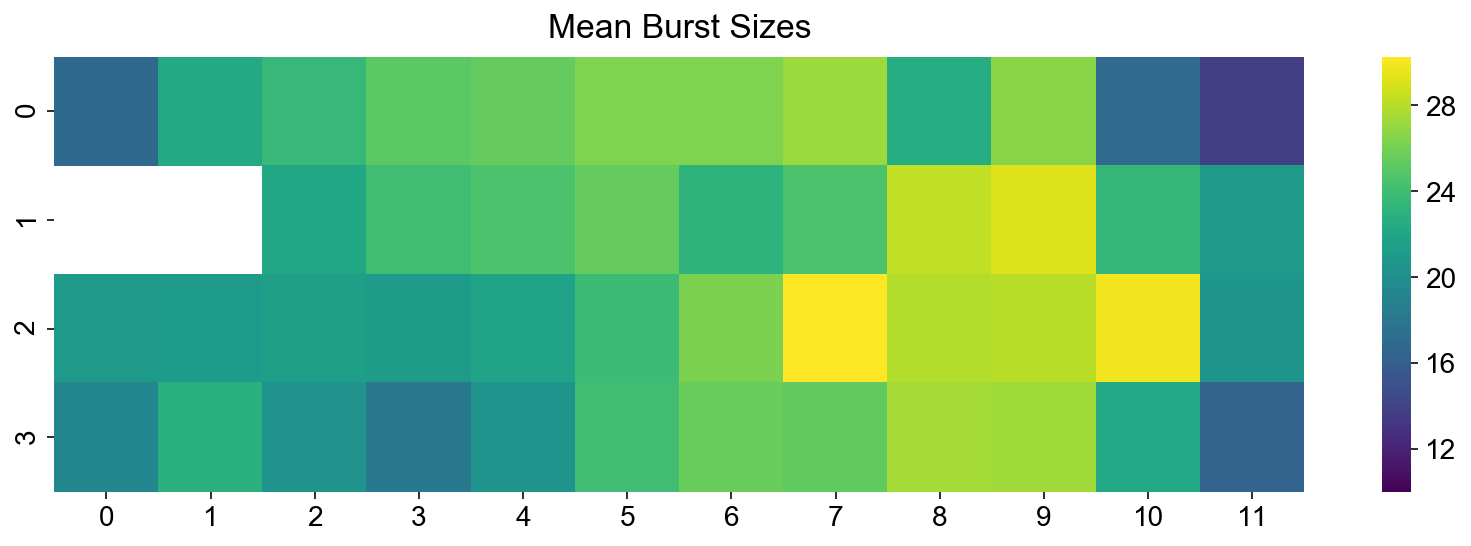

In [42]:
heatmap48(bs_mean, cmap='viridis', skip_ch=skip_ch,
          title="Mean Burst Sizes", vmin=10)
savefig('heatmap_burst_sizes')

<IPython.core.display.Math object>

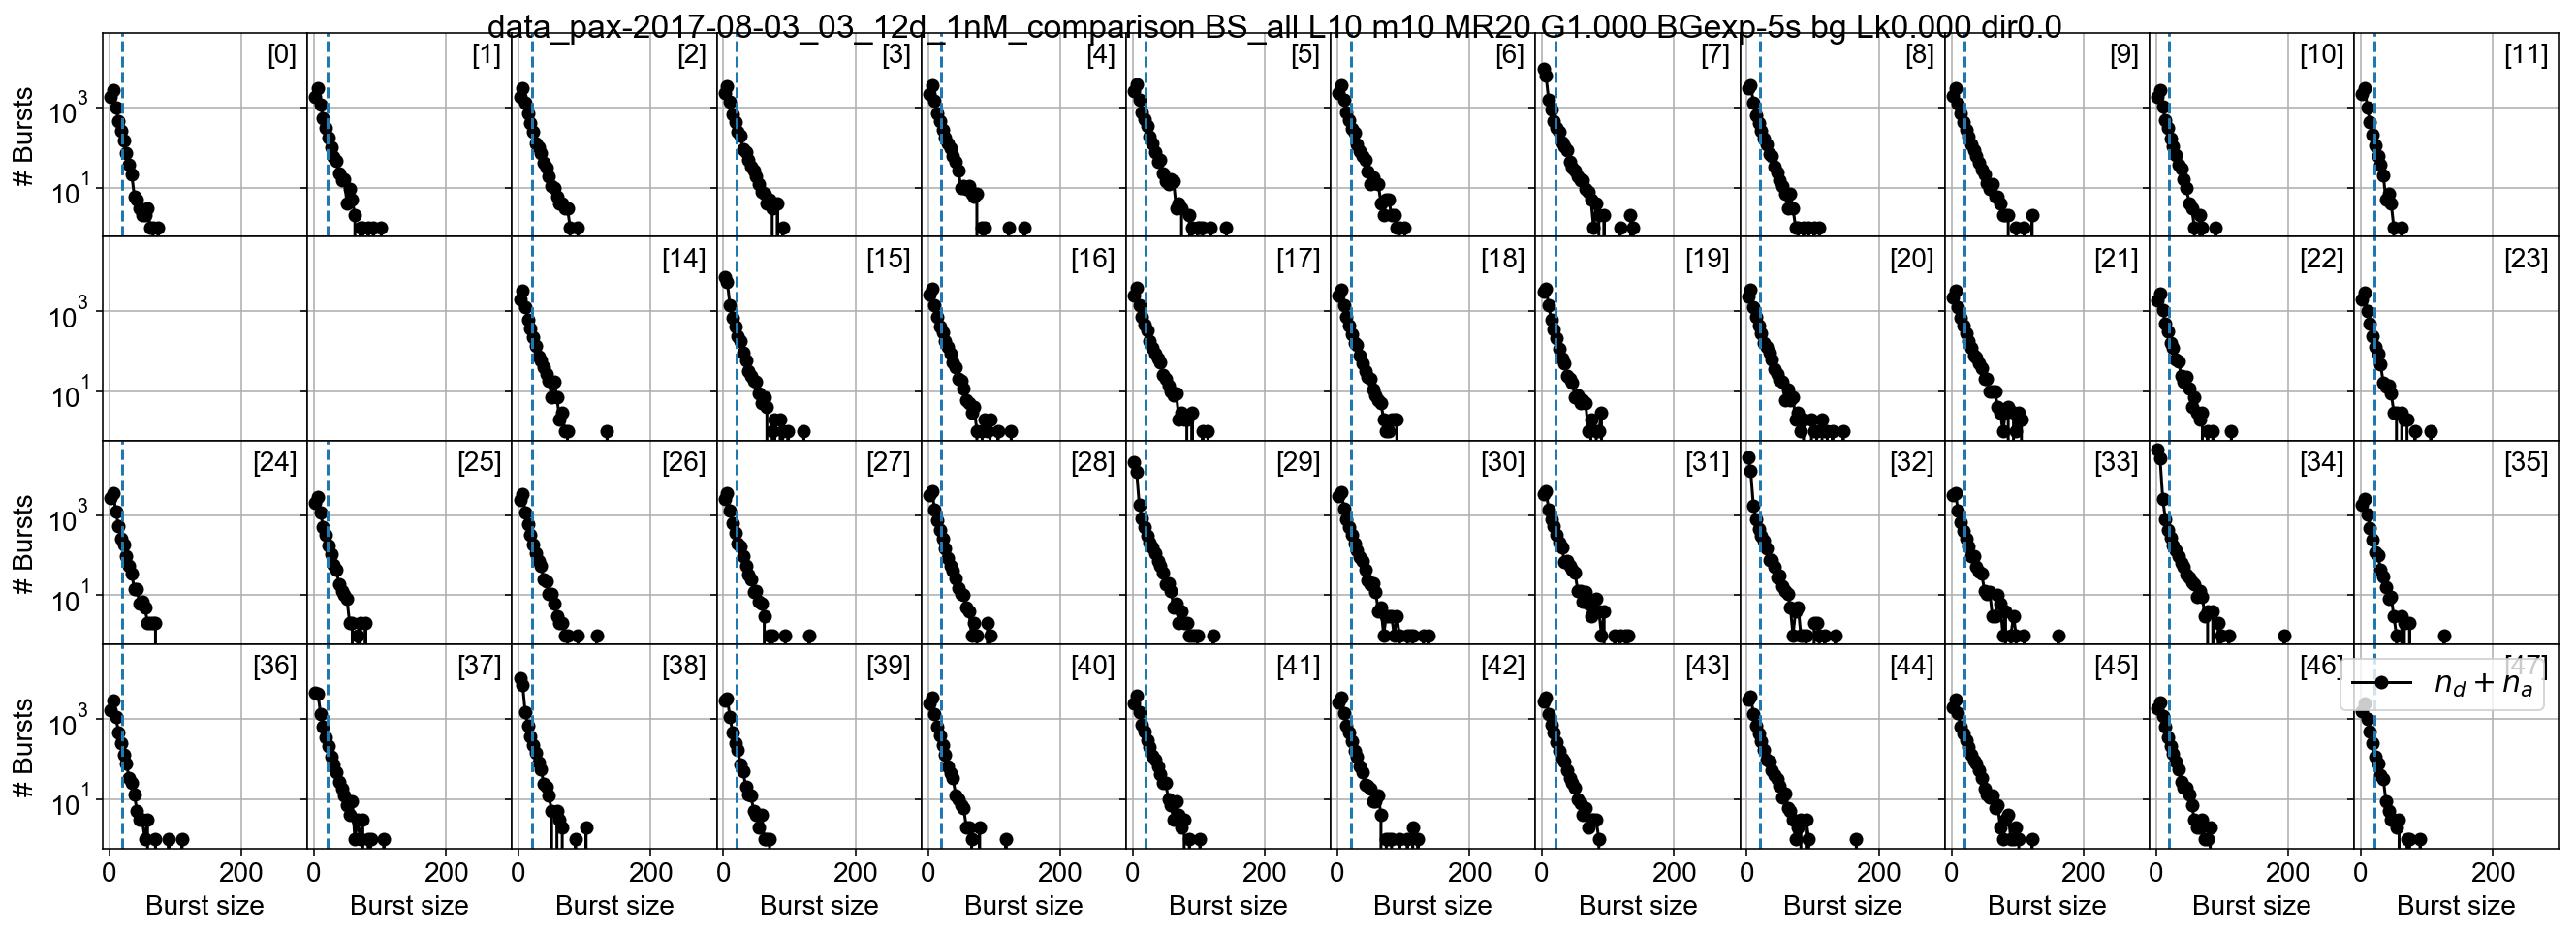

In [43]:
size_th = 20
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem'),
                    na_comp=False, naa_comp=False, naa_aexonly=False)
dplot(d, hist_size, vline=size_th, **size_sel_kws, **kws);
plt.xlim(-10, 300)
plt.legend(fontsize=15, loc='upper right');
Math(d._burst_sizes_pax_formula(**size_sel_kws))

(-27.600000000000001, 300)

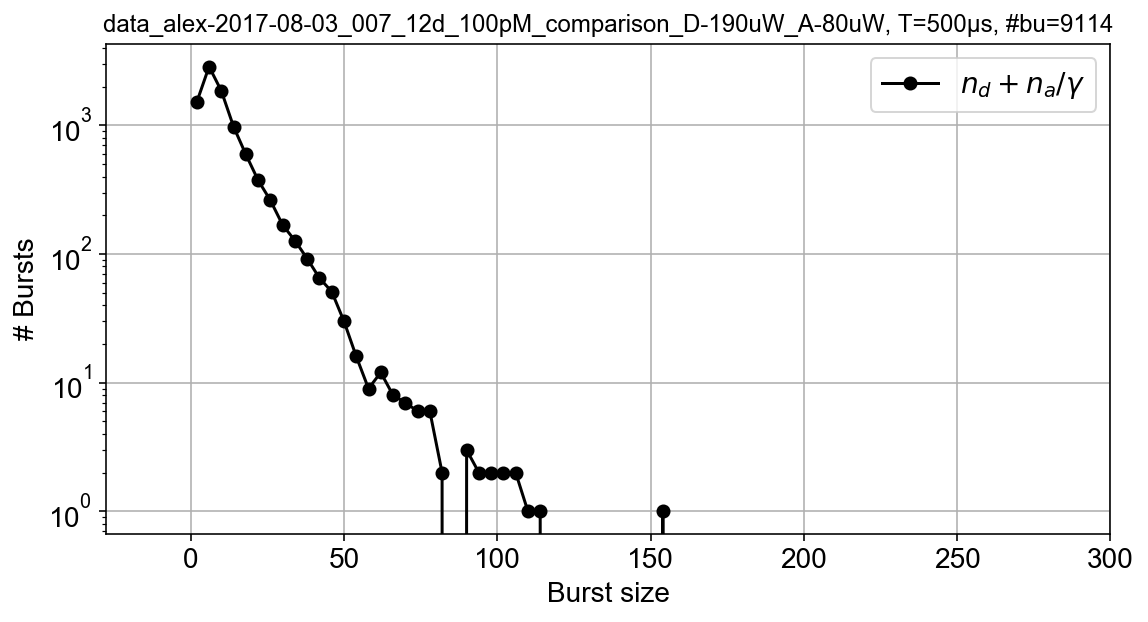

In [44]:
dplot(dax, hist_size)
plt.xlim(None, 300)

# Burst duration

## Multispot

In [45]:
width_th = 0.8

(-0.5, 6)

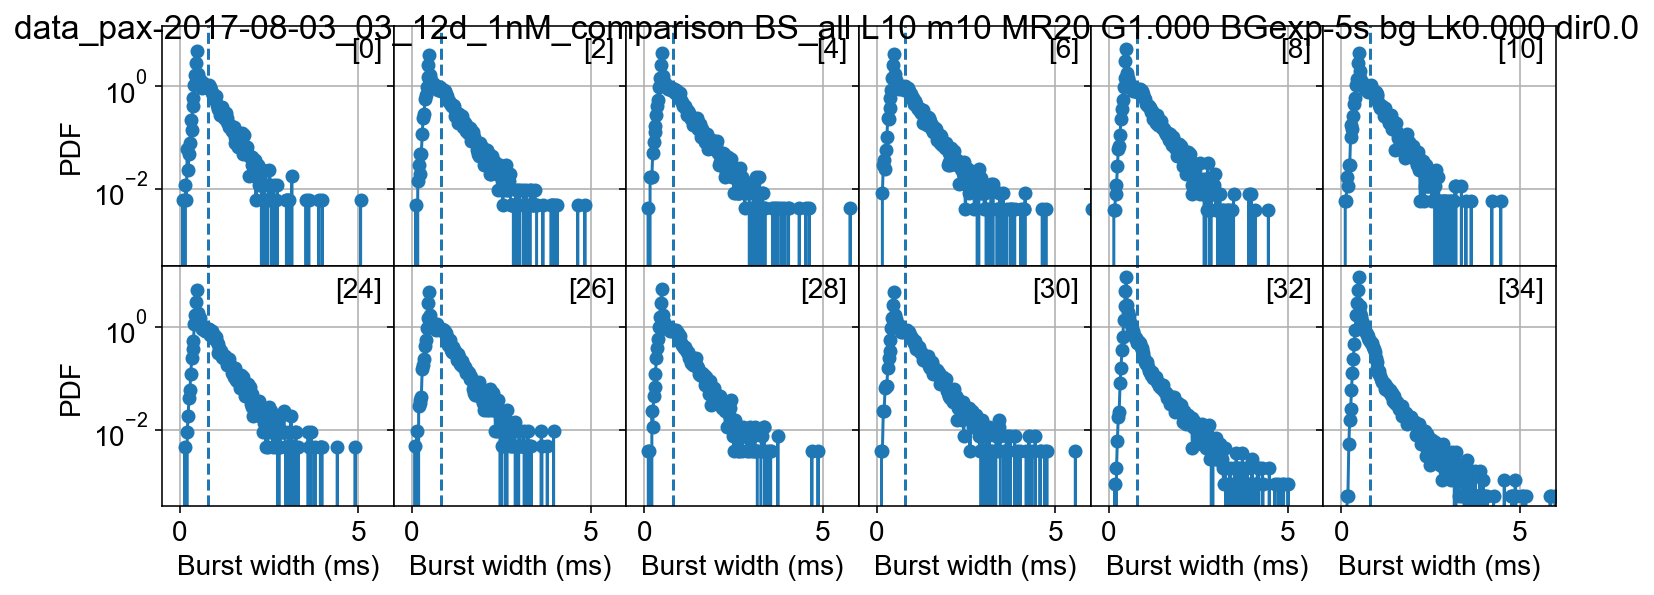

In [46]:
dplot(d, hist_width, vline=width_th, dec=2, **kws);
plt.xlim(-0.5, 6)

In [47]:
Width_th = np.arange(0.2, 2, 0.05)

In [48]:
width_vs_th = np.zeros((48, Width_th.size))
for ich in range(48):
    if d.num_bursts[ich] < 100:
        continue
    for iw, width_th in enumerate(Width_th):
        widths_ch = d.mburst[ich].width * d.clk_p * 1e3
        tail = widths_ch > width_th
        width_vs_th[ich,iw] = widths_ch[tail].mean() - width_th

## ALEX

In [49]:
width_th = 0.8

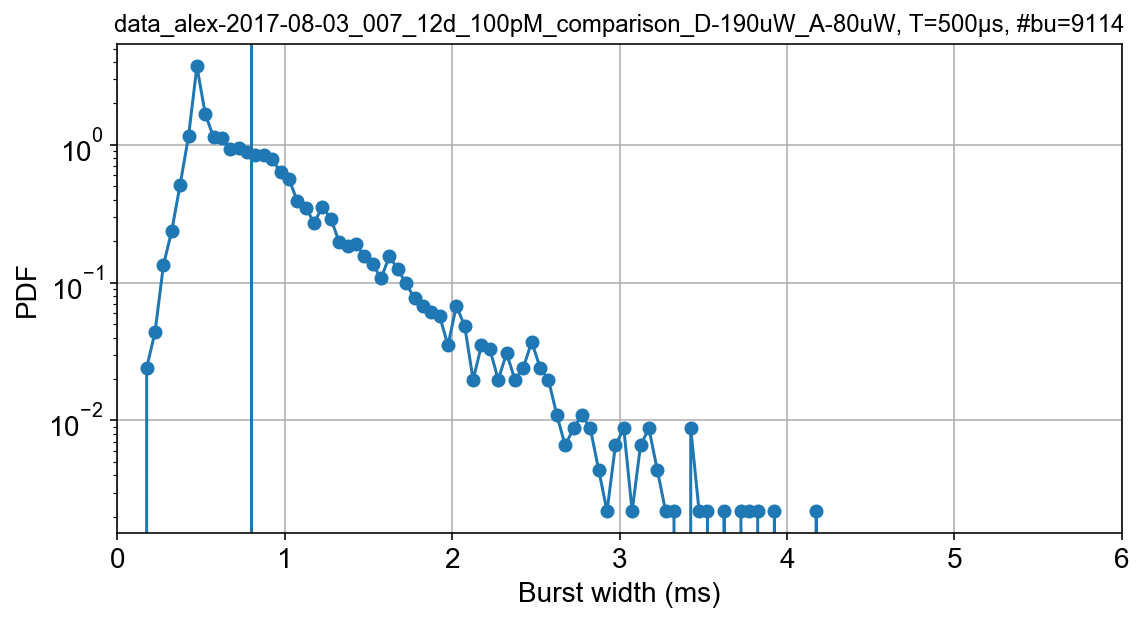

In [50]:
dplot(dax, hist_width, bins=(0, 10, 0.05))
plt.xlim(0, 6)
plt.axvline(width_th)

In [51]:
width_vs_th_alex = []
for width_th in Width_th:
    widths_ch = dax.mburst[0].width * dax.clk_p * 1e3
    tail = widths_ch > width_th
    width_vs_th_alex.append(widths_ch[tail].mean() - width_th)

## Duration comparison

In [52]:
w_th = 0.9
iw_th = int(np.where(np.abs(Width_th - w_th) < 1e-12)[0])
iw_th

14

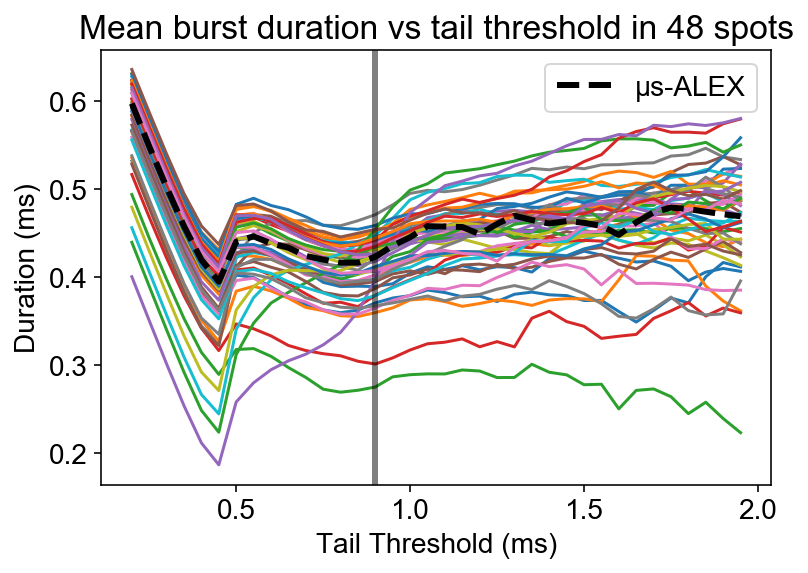

In [53]:
plt.plot(Width_th, width_vs_th.T);
plt.plot(Width_th, width_vs_th_alex, lw=3, ls='--', color='k', label='μs-ALEX');
plt.title('Mean burst duration vs tail threshold in 48 spots')
plt.xlabel('Tail Threshold (ms)')
plt.axvline(w_th, lw=3, alpha=0.5, color='k')
plt.legend()
plt.ylabel('Duration (ms)');

In [54]:
bw_mean = width_vs_th[:,iw_th].ravel()

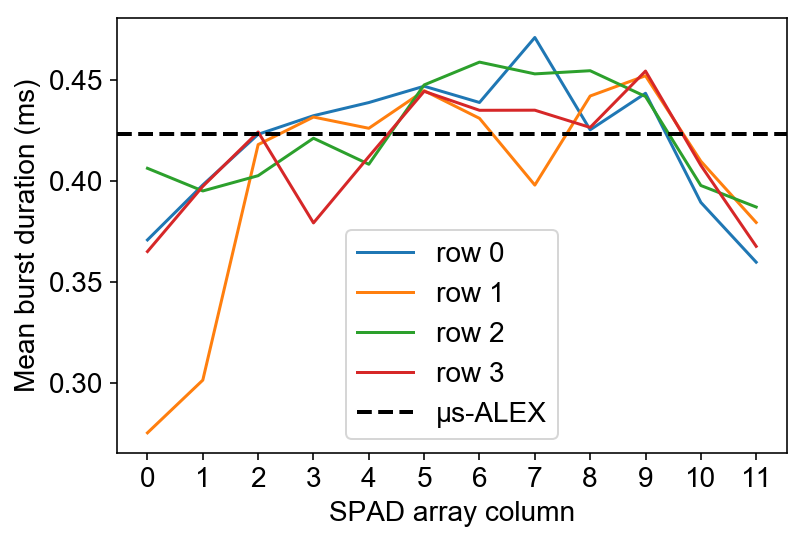

In [55]:
plt.plot(bw_mean.reshape(4, 12).T, label='line x')
plt.axhline(width_vs_th_alex[iw_th], ls='--', color='k', lw=2, label='μs-ALEX')
plt.xlabel('SPAD array column')
plt.xticks(range(12))
plt.ylabel('Mean burst duration (ms)')
plt.legend(['row %d' %i for i in range(4)] + ['μs-ALEX']);

Saved: figures/2017-08-03_03_12d_heatmap_burst_widths.png
Saved hires: figures/2017-08-03_03_12d_heatmap_burst_widths_highres.png


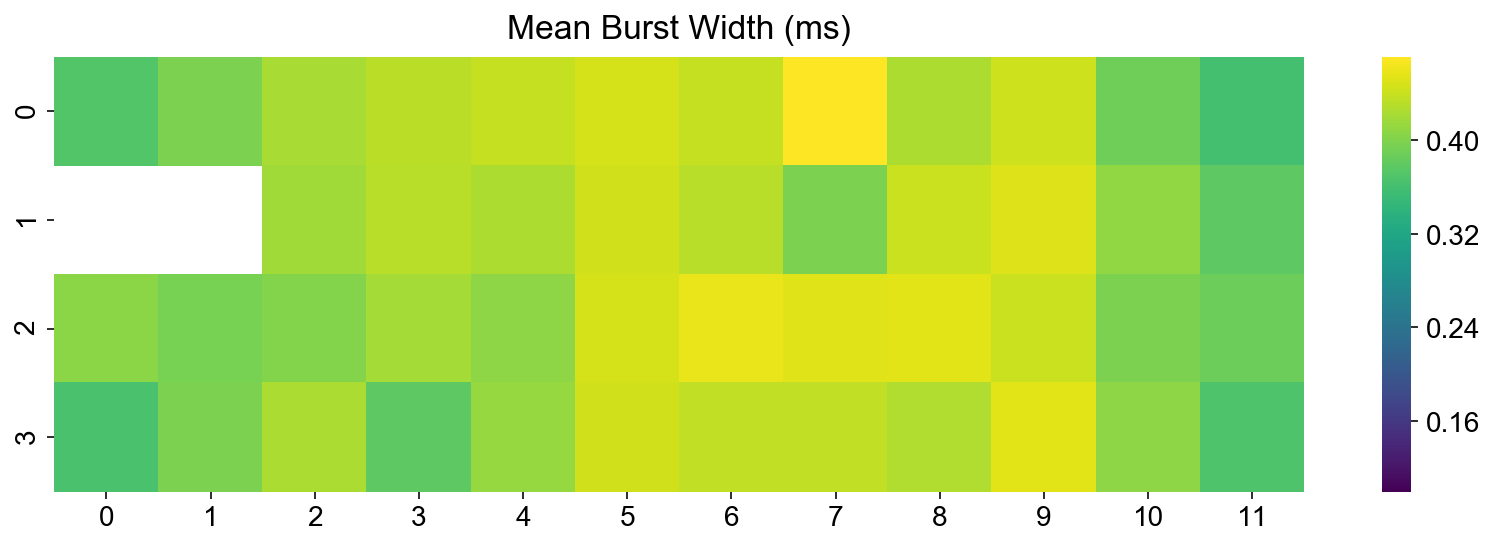

In [56]:
heatmap48(bw_mean, cmap='viridis', skip_ch=skip_ch,
          title="Mean Burst Width (ms)", vmin=0.1)
savefig('heatmap_burst_widths')

# Peak photon rate

In [57]:
# Use recompute=True if changing burst-search parameters
recompute = False
phrates = {}
streams = ('all', 'DexDem', 'AexDem', 'DexAem', 'AexAem', )
for stream in streams:
    print(' - Computing peak photon rates for %6s stream.' % str(Ph_sel.from_str(stream)))
    cal_phrate(d, stream=Ph_sel.from_str(stream), phrates=phrates, recompute=recompute)

 - Computing peak photon rates for    all stream.
   Valid fraction (mean of all ch): 100.0 %
 - Computing peak photon rates for DexDem stream.
   Valid fraction (mean of all ch): 9.6 %
 - Computing peak photon rates for AexDem stream.
   Valid fraction (mean of all ch): 9.9 %
 - Computing peak photon rates for DexAem stream.
   Valid fraction (mean of all ch): 11.3 %
 - Computing peak photon rates for AexAem stream.
   Valid fraction (mean of all ch): 28.1 %


Saved: figures/2017-08-03_03_12d_peak_phrate_all.png
Saved hires: figures/2017-08-03_03_12d_peak_phrate_all_highres.png


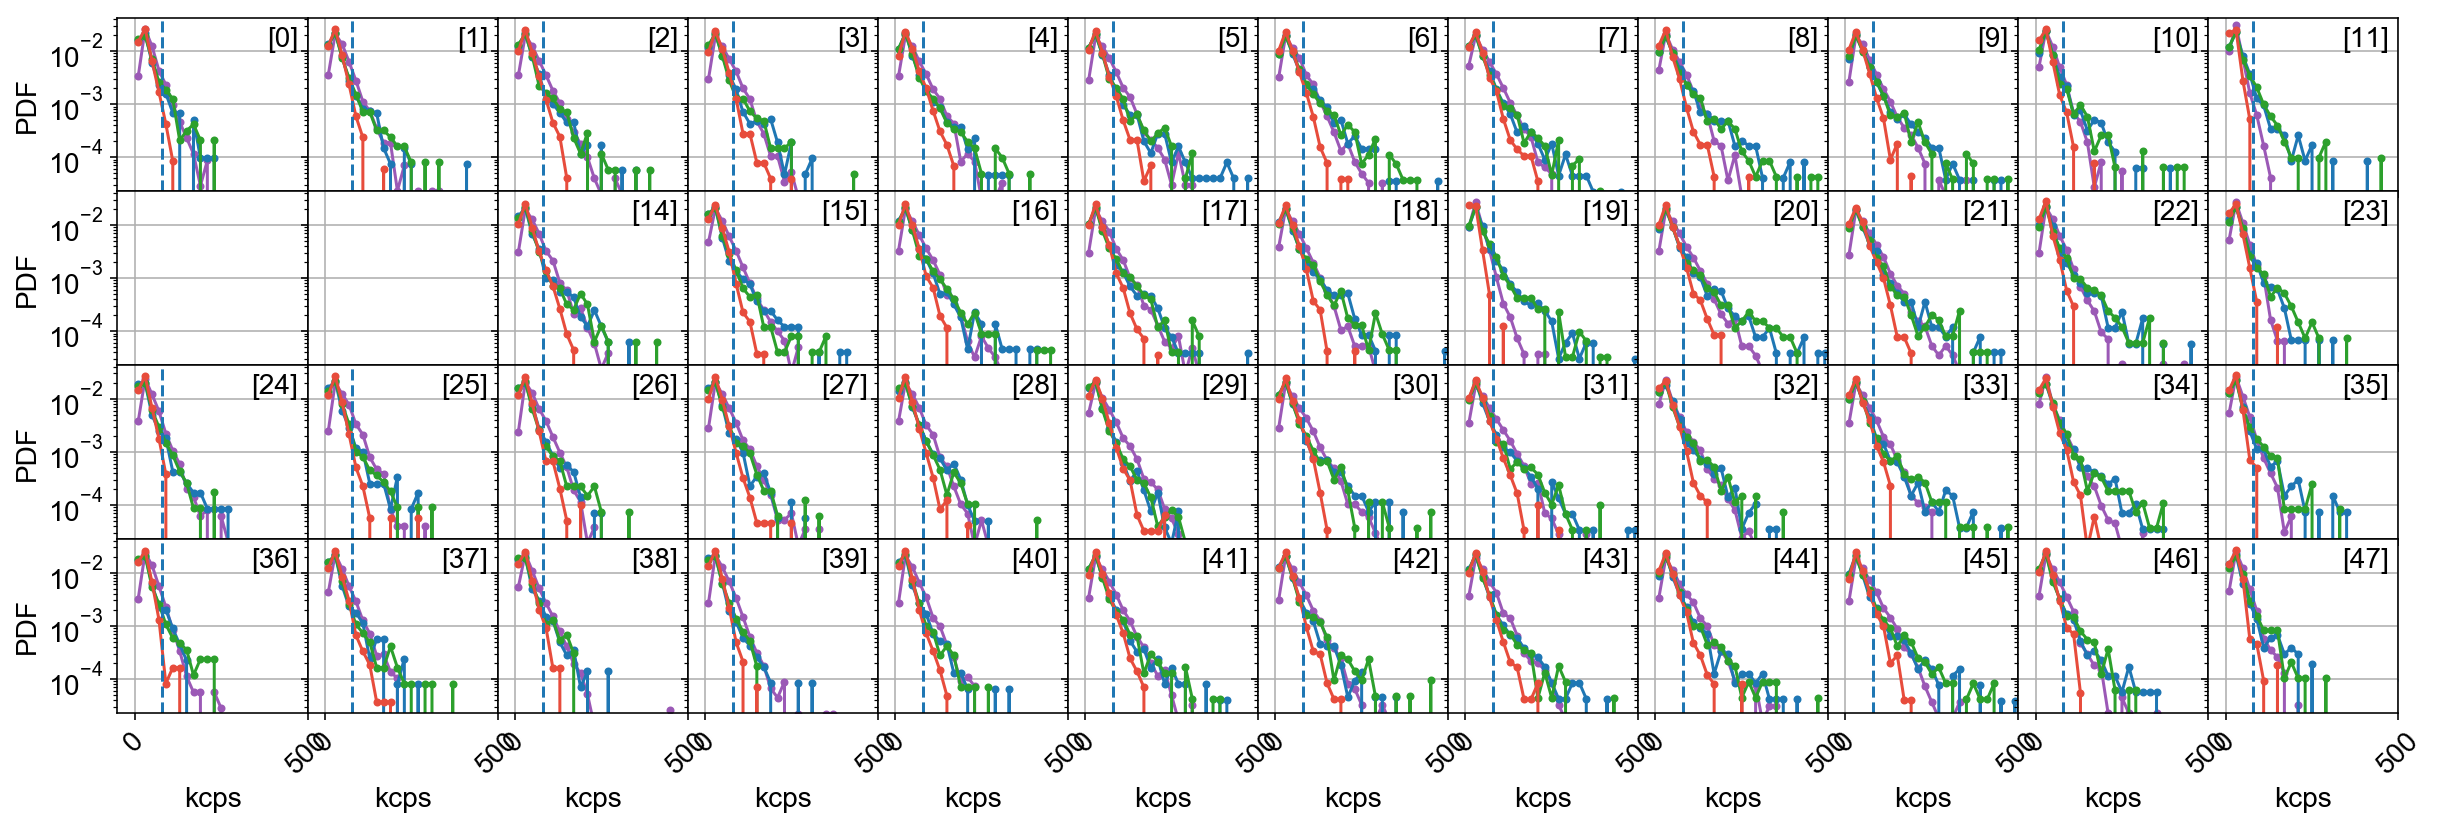

In [58]:
kws = dict(figsize=(18, 6), skip_ch=skip_ch, wspace=0, hspace=0, grid=True, 
           title=None, title_nbursts=False, title_bg=False, xrotation=45)

ax = dplot(phrates['AexAemB'], hist_burst_phrate, 
           plot_style=dict(color=bpl.purple, ms=3), **kws);
dplot(phrates['AexDemB'], hist_burst_phrate, 
      plot_style=dict(color='C0', ms=3), AX=ax, **kws);
dplot(phrates['DexDemB'], hist_burst_phrate, 
      plot_style=dict(color=bpl.green, ms=3), AX=ax, **kws);
kws.update(vline=80, title='in', title_nbursts=False, title_bg=False,)
dplot(phrates['DexAemB'], hist_burst_phrate, 
      plot_style=dict(color=bpl.red, ms=3), AX=ax, **kws);
plt.xlim(-50, 500);
plt.setp(ax[:, 0], ylabel='PDF')
plt.setp(ax[-1], xlabel='kcps')
savefig('peak_phrate_all')

In [59]:
phr_th = 80e3
for stream in streams:
    phrates[stream]['mean'] = 0
    phr = phrates[stream+'B']
    for ich in range(48):
        valid = ~pd.isnull(phr[ich])
        phr_valid = phr[ich][valid]
        m = phr_valid[phr_valid >= phr_th].mean() - phr_th
        phrates[stream].loc[ich, 'mean'] = np.round(m*1e-3, 1)

In [60]:
streams

('all', 'DexDem', 'AexDem', 'DexAem', 'AexAem')

Saved: figures/2017-08-03_03_12d_peak_phrate_heatmap_all.png
Saved hires: figures/2017-08-03_03_12d_peak_phrate_heatmap_all_highres.png
Saved: figures/2017-08-03_03_12d_peak_phrate_heatmap_DexDem.png
Saved hires: figures/2017-08-03_03_12d_peak_phrate_heatmap_DexDem_highres.png
Saved: figures/2017-08-03_03_12d_peak_phrate_heatmap_AexDem.png
Saved hires: figures/2017-08-03_03_12d_peak_phrate_heatmap_AexDem_highres.png
Saved: figures/2017-08-03_03_12d_peak_phrate_heatmap_DexAem.png
Saved hires: figures/2017-08-03_03_12d_peak_phrate_heatmap_DexAem_highres.png
Saved: figures/2017-08-03_03_12d_peak_phrate_heatmap_AexAem.png
Saved hires: figures/2017-08-03_03_12d_peak_phrate_heatmap_AexAem_highres.png


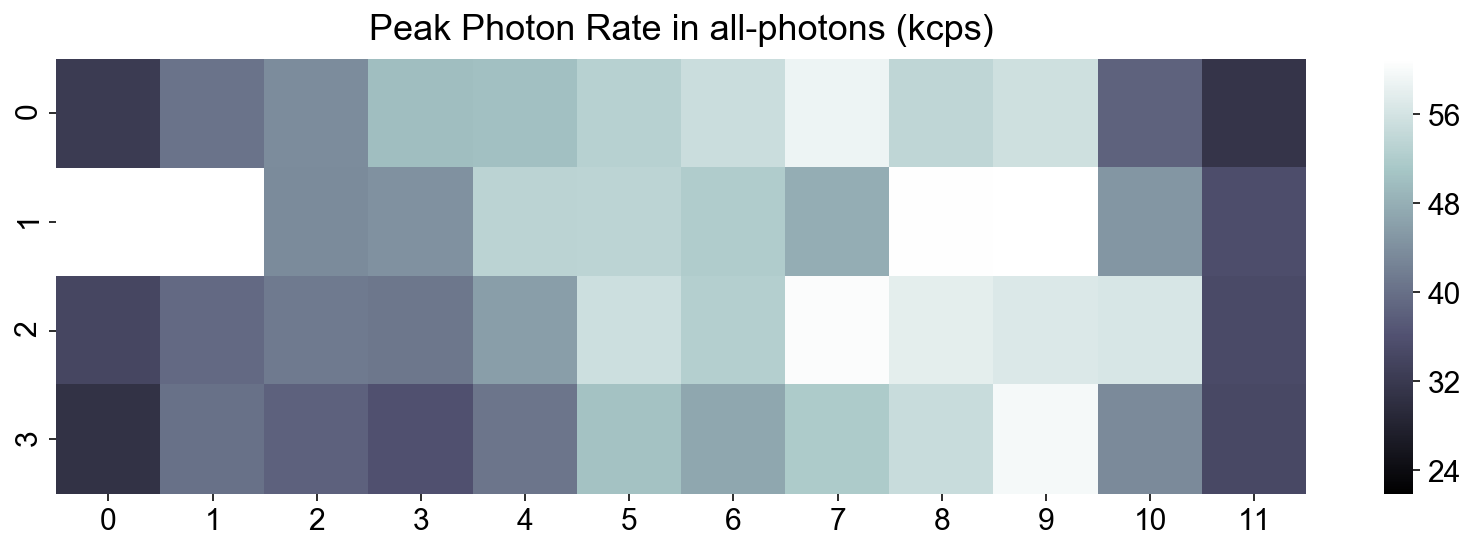

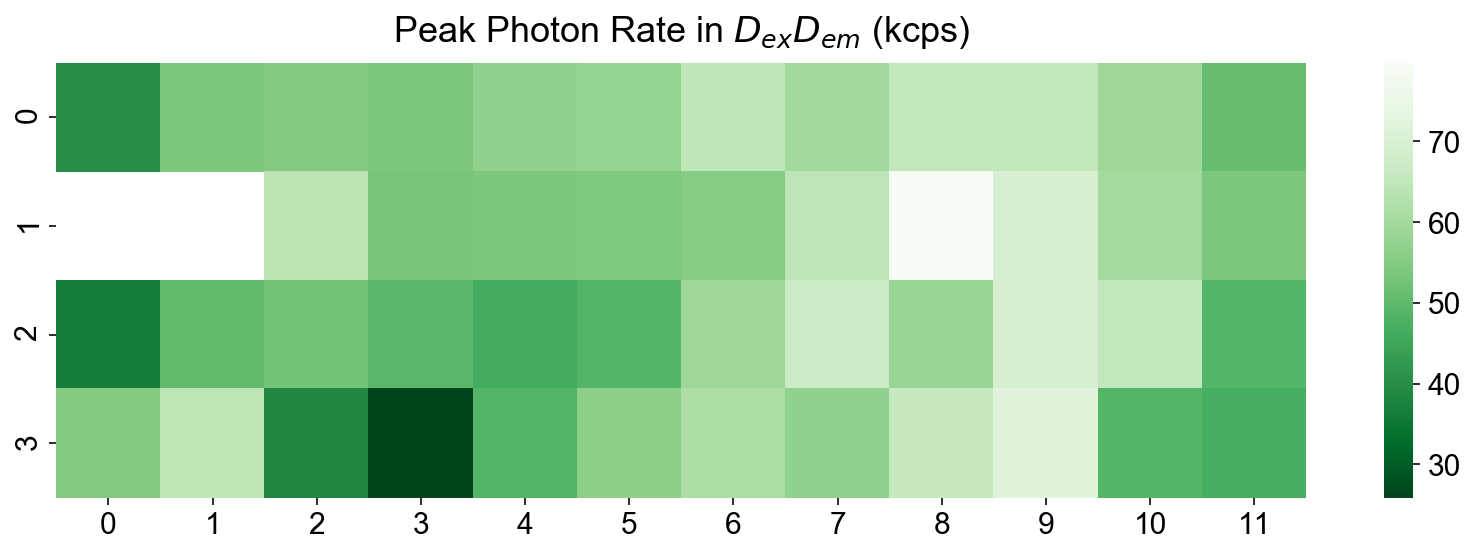

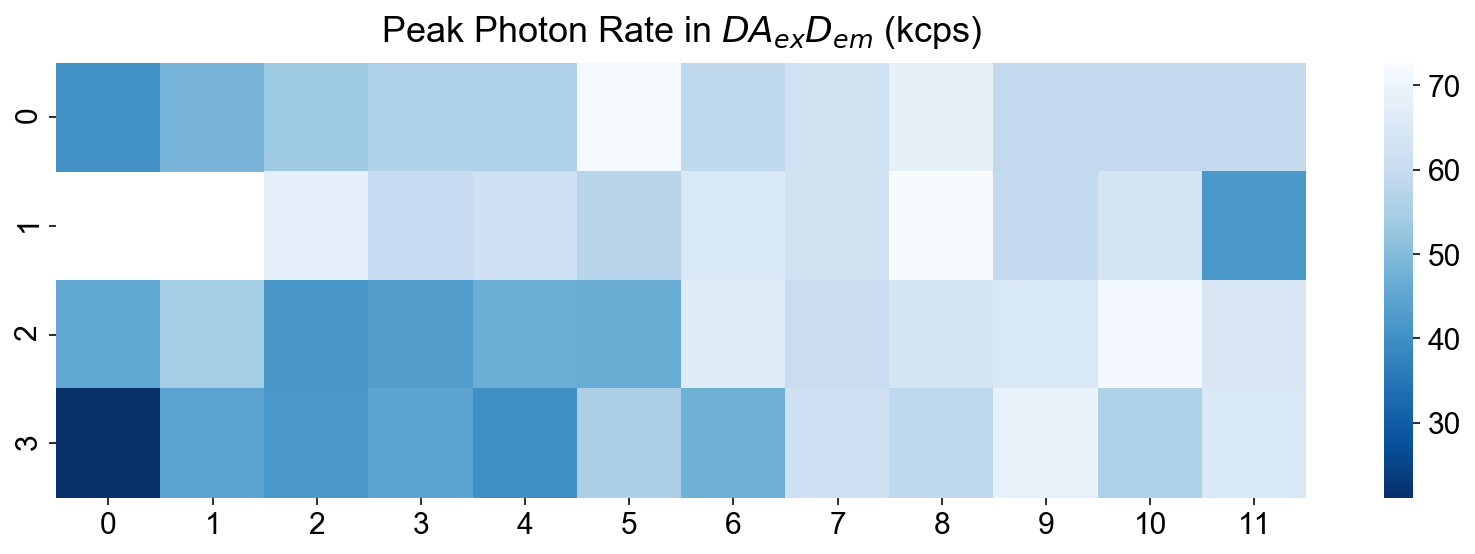

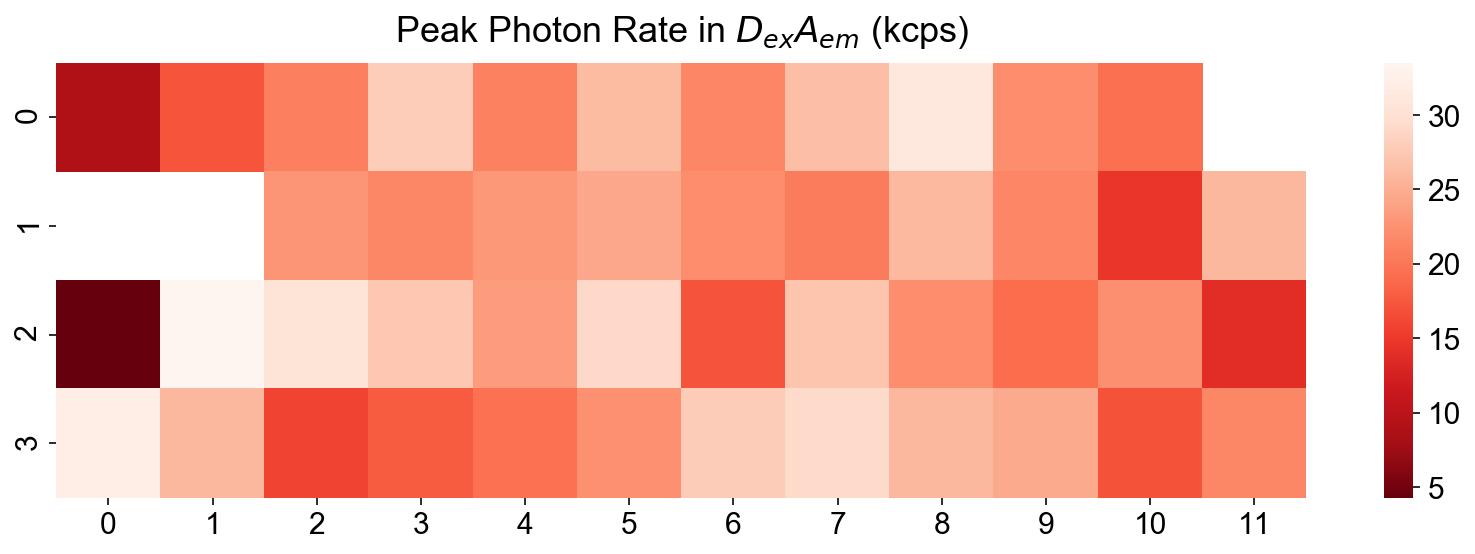

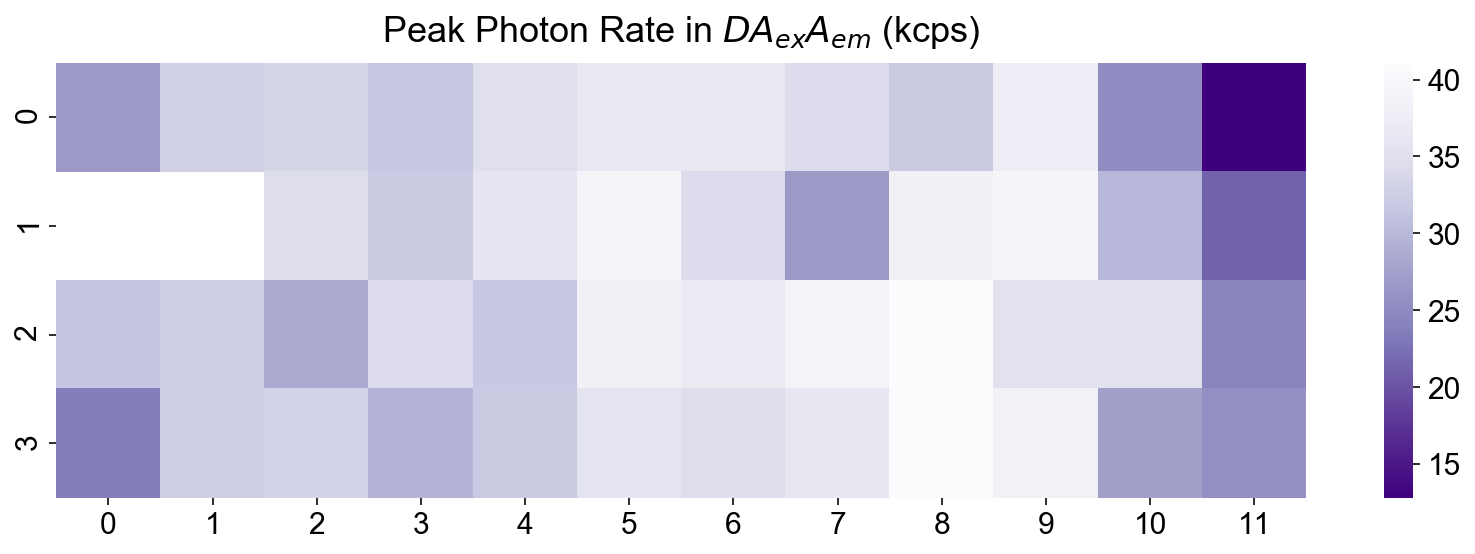

In [61]:
cmaps = ('bone', 'Greens_r', 'Blues_r', 'Reds_r', 'Purples_r')
label = {'DexDem': '$D_{ex}D_{em}$', 'DexAem': '$D_{ex}A_{em}$',
         'AexDem': '$DA_{ex}D_{em}$', 'AexAem': '$DA_{ex}A_{em}$', 'all': 'all-photons'}
with plt.rc_context({'font.size': 15}):
    for stream, cmap in zip(streams, cmaps):
        heatmap48(phrates[stream]['mean'], cmap=cmap, skip_ch=skip_ch,
                  title=r"Peak Photon Rate in %s (kcps)" % label[stream])
        savefig('peak_phrate_heatmap_%s' % stream)

In [62]:
dax.calc_max_rate(m=10, ph_sel=Ph_sel(Dex='Dem'), compact=True)

In [63]:
recompute = False
streams_a = ('DexDem', 'DexAem', 'AexAem')
colors = (bpl.green, bpl.red, bpl.purple)
phrates_alex = {}
for stream in streams_a:
    print(' - Computing peak photon rates for %6s stream.' % str(Ph_sel.from_str(stream)))
    cal_phrate_alex(dax, stream=Ph_sel.from_str(stream), phrates=phrates_alex, recompute=recompute)

 - Computing peak photon rates for DexDem stream.
   Valid fraction (mean of all ch): 11.4 %
 - Computing peak photon rates for DexAem stream.
   Valid fraction (mean of all ch): 23.8 %
 - Computing peak photon rates for AexAem stream.
   Valid fraction (mean of all ch): 37.4 %


In [64]:
phrates_alex[stream]

{'num_bursts': 8459,
 'num_nans': 5299,
 'num_valid': 3160,
 'valid_fraction': 37.356661543917724}

Saved: figures/2017-08-03_007_12d_usALEX_peak_phrate.png
Saved hires: figures/2017-08-03_007_12d_usALEX_peak_phrate_highres.png


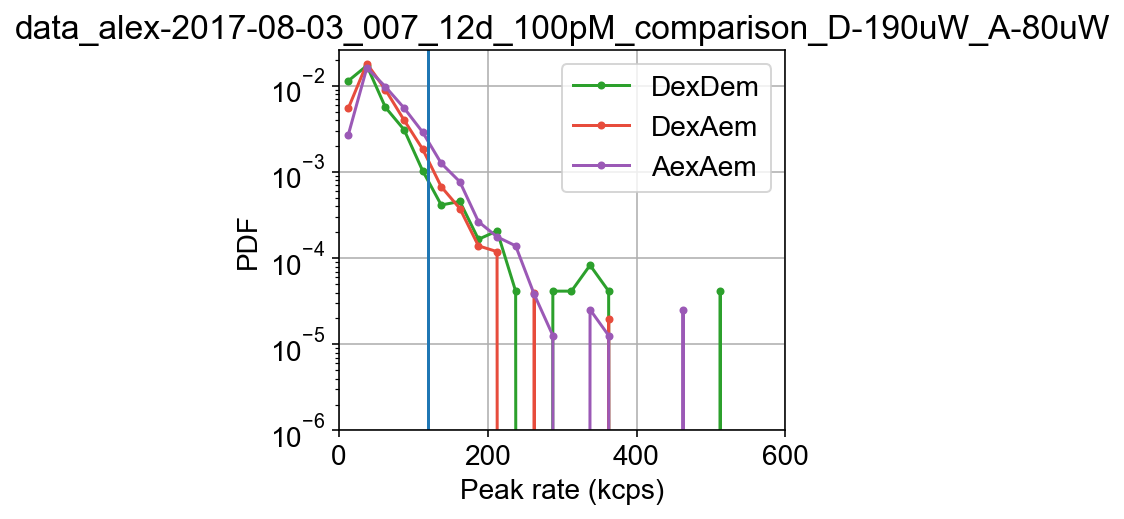

In [65]:
fig, ax = plt.subplots(figsize=(4, 3.5))
bins = (0, 2000, 25)
for stream, color in zip(streams_a, colors):
    hist_burst_phrate(phrates_alex[stream+'B'], bins=bins, plot_style=dict(color=color, ms=3, label=stream))
plt.xlim(0, 600)
plt.ylim(1e-6)
plt.title(dax.name)
plt.legend()
plt.grid(True)
plt.axvline(120)
savefig('usALEX_peak_phrate', label=mlabel_alex)

In [66]:
phr_th = 120e3
for stream in streams_a:
    phr = phrates_alex[stream+'B']
    ich = 0
    valid = ~pd.isnull(phr[ich])
    phr_valid = phr[ich][valid]
    m = phr_valid[phr_valid >= phr_th].mean() - phr_th
    phrates_alex[stream]['mean'] = np.round(m*1e-3, 1)
    print('Mean peak photon rate %s: %.1f kcps' % (stream, phrates_alex[stream]['mean']))

Mean peak photon rate DexDem: 73.8 kcps
Mean peak photon rate DexAem: 34.7 kcps
Mean peak photon rate AexAem: 40.4 kcps


# Burst selection

In [67]:
size_Dex = 80
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
Math(d._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

In [68]:
size_Aex = 20
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=0.5,
                   na_comp=False, naa_comp=False, naa_aexonly=False)

Math(d._burst_sizes_pax_formula(**naa_sel_kws))

<IPython.core.display.Math object>

In [69]:
ds = d.select_bursts(select_bursts.size, th1=size_Dex, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds.nd, ds.na, ds.naa)]
ds.add(Su=Su)
dss = ds.select_bursts(select_bursts.size, th1=size_Aex, **naa_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dss.nd, dss.na, dss.naa)]
dss.add(Su=Su)

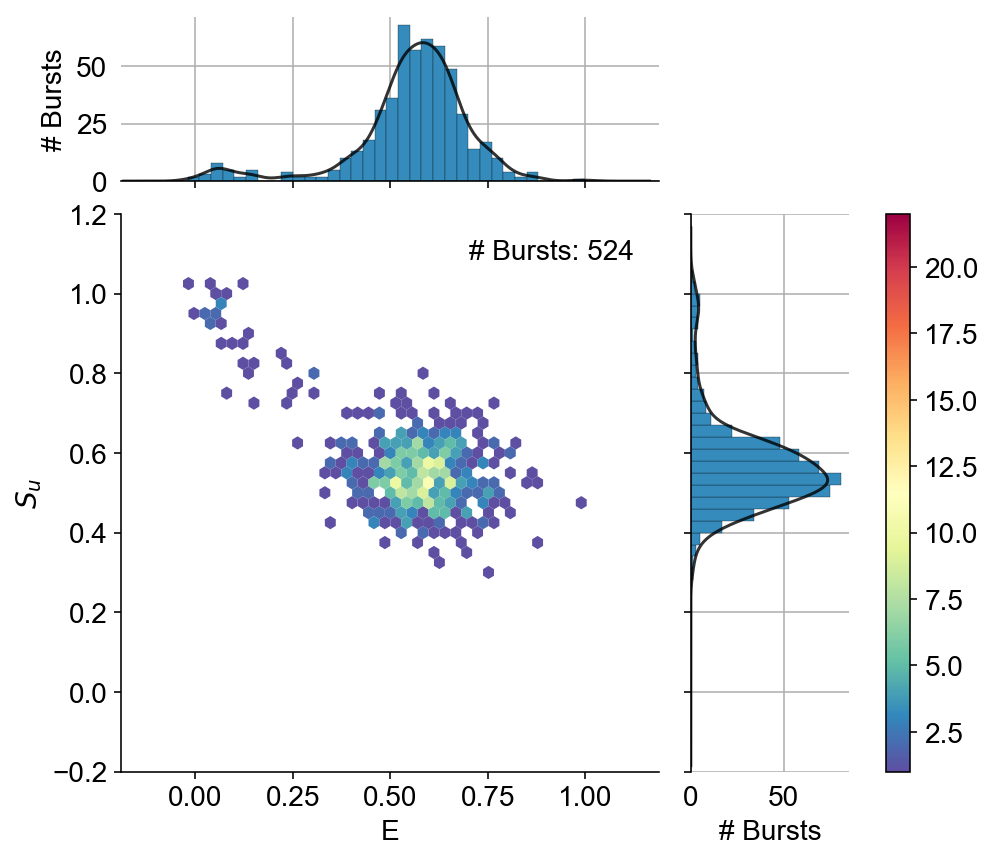

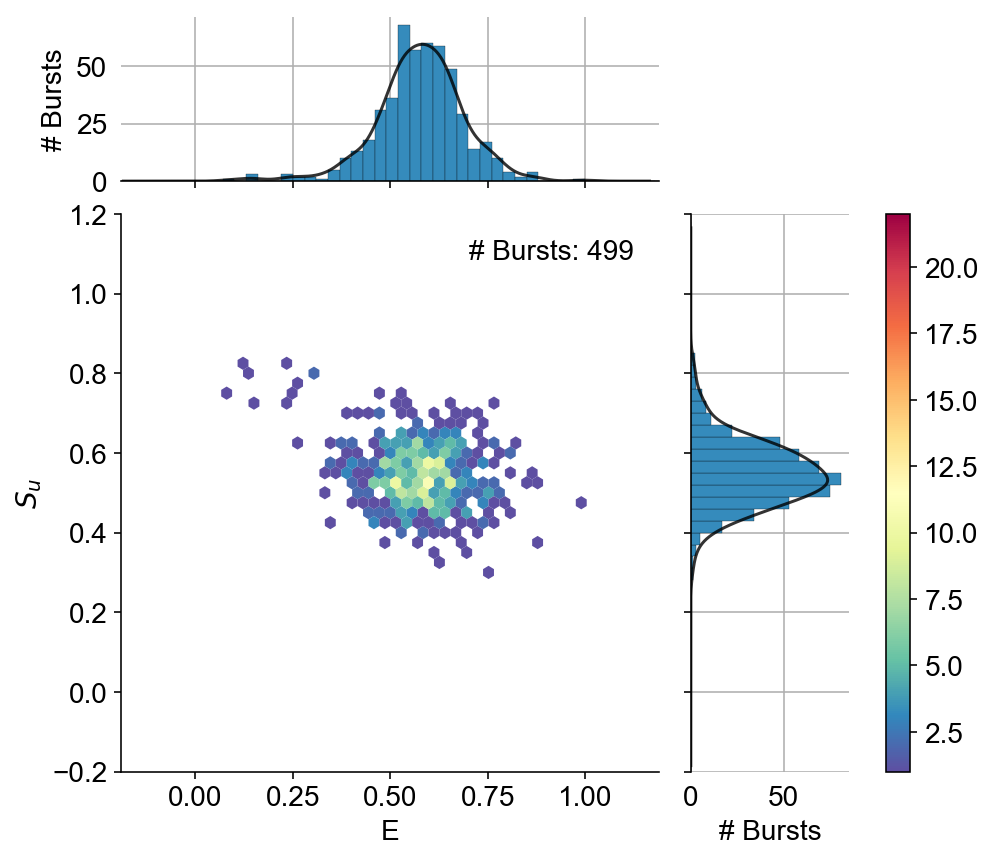

In [70]:
g = alex_jointplot(ds, i=30, vmax=22, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')
g = alex_jointplot(dss, i=30, vmax=22, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')

In [71]:
dssc = dss.collapse(update_gamma=False, skip_ch=skip_ch)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dssc.nd, dssc.na, dssc.naa)]
dssc.add(Su=Su)
E_pr_pax = np.median(dssc.E[0])
E_pr_pax

0.58043264988472754

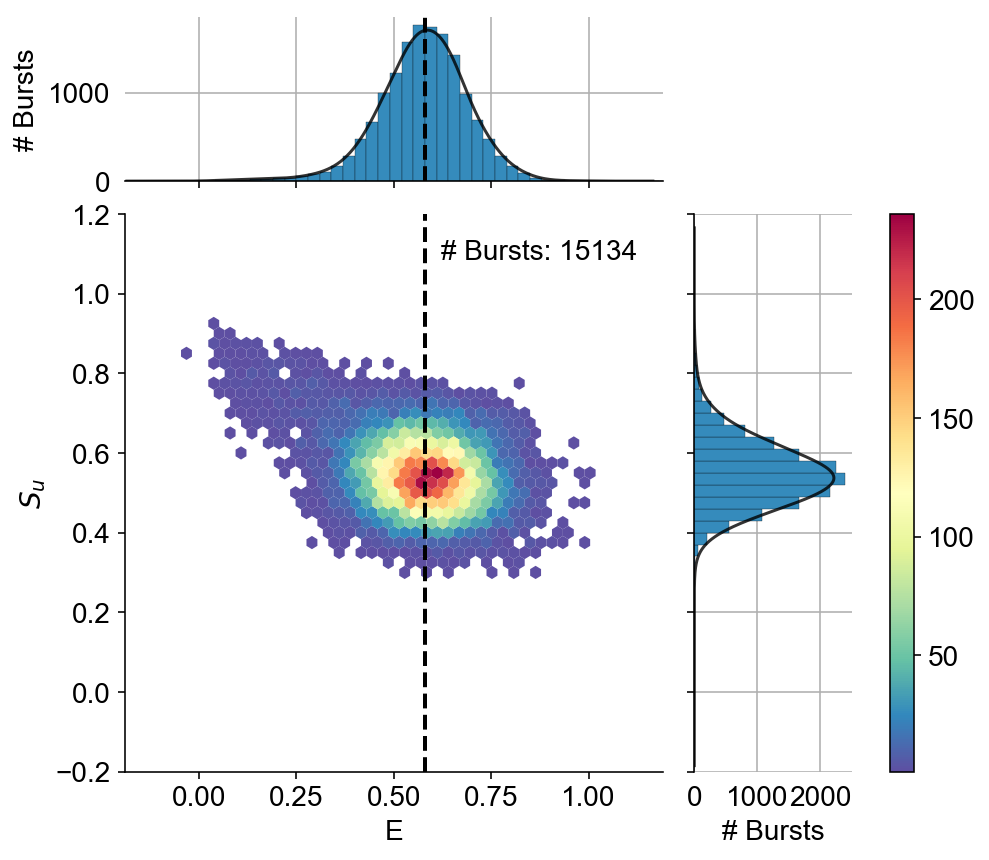

In [72]:
g = alex_jointplot(dssc, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')
g.ax_joint.axvline(E_pr_pax, lw=2, ls='--', color='k')
g.ax_marg_x.axvline(E_pr_pax, lw=2, ls='--', color='k');

The calibrated $E$ for this sample (12d) was computed in [Ingargiola et al. 2017](https://doi.org/10.1371/journal.pone.0175766). Here we used this calibrated value
to extract the $\gamma$ factor of both 48-pspot PAX and 1-spot ALEX setups using the
formula:

$$\gamma = \frac{{E}^{-1} - 1}{{E_{PR}}^{-1} - 1}$$

The calibrated $E$ value is taken from [this notebook](http://nbviewer.jupyter.org/github/tritemio/multispot_paper/blob/master/index.ipynb#μs-ALEX:-Corrected-E-figure).

In [73]:
E_calib = 0.727

In [74]:
gamma_pax = (1/E_calib - 1) / (1/E_pr_pax - 1)
gamma_pax

0.51949142731478959

# Collapse

In [75]:
d.num_bursts.sum()

576957

In [76]:
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=1,
                   na_comp=False, naa_comp=False, naa_aexonly=False)

Math(d._burst_sizes_pax_formula(**naa_sel_kws))

<IPython.core.display.Math object>

In [77]:
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)

Math(d._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

In [78]:
dc = d.collapse(update_gamma=False, skip_ch=skip_ch)

In [79]:
size_th = 80
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
dcs = dc.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcs.nd, dcs.na, dcs.naa)]
dcs.add(Su=Su)
Math(d._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

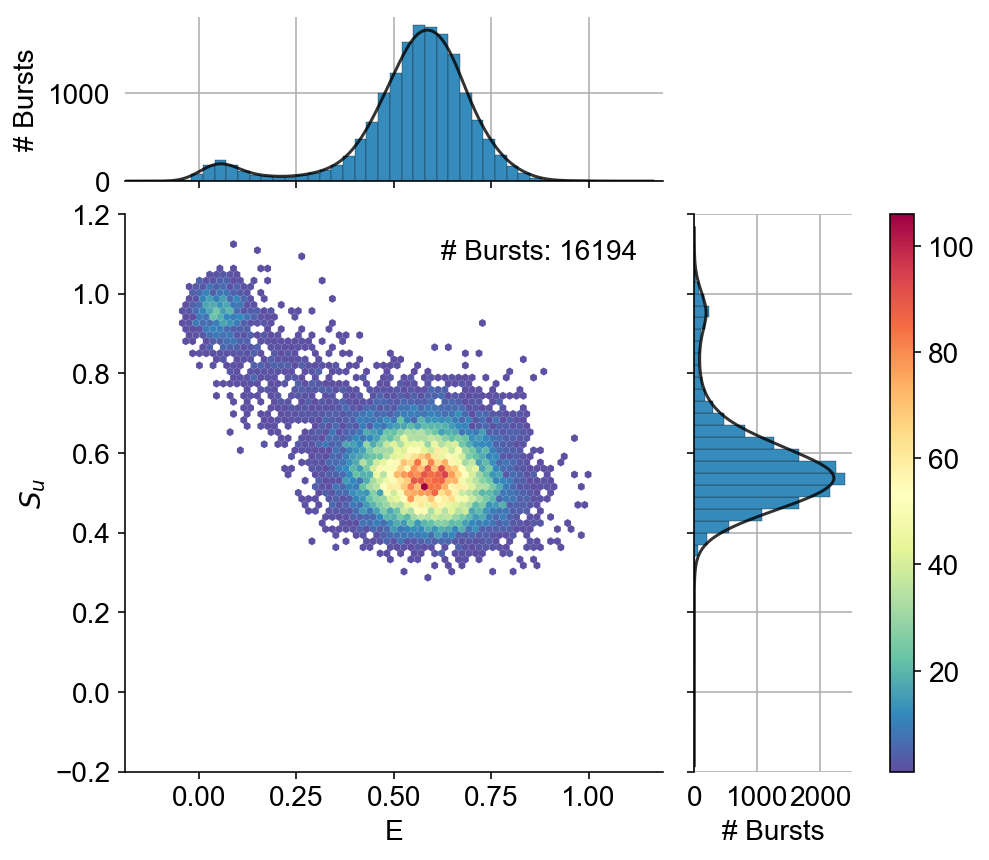

In [80]:
g = alex_jointplot(dcs, S_name='Su', vmax_fret=True, gridsize=80)
g.ax_joint.set_ylabel('$S_u$');

In [81]:
dcs5 = dcs.select_bursts(select_bursts.time, time_s1=0, time_s2=5)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcs5.nd, dcs5.na, dcs5.naa)]
dcs5.add(Su=Su)

Saved: figures/2017-08-03_03_12d_alex_jointplot_5s.png
Saved hires: figures/2017-08-03_03_12d_alex_jointplot_5s_highres.png


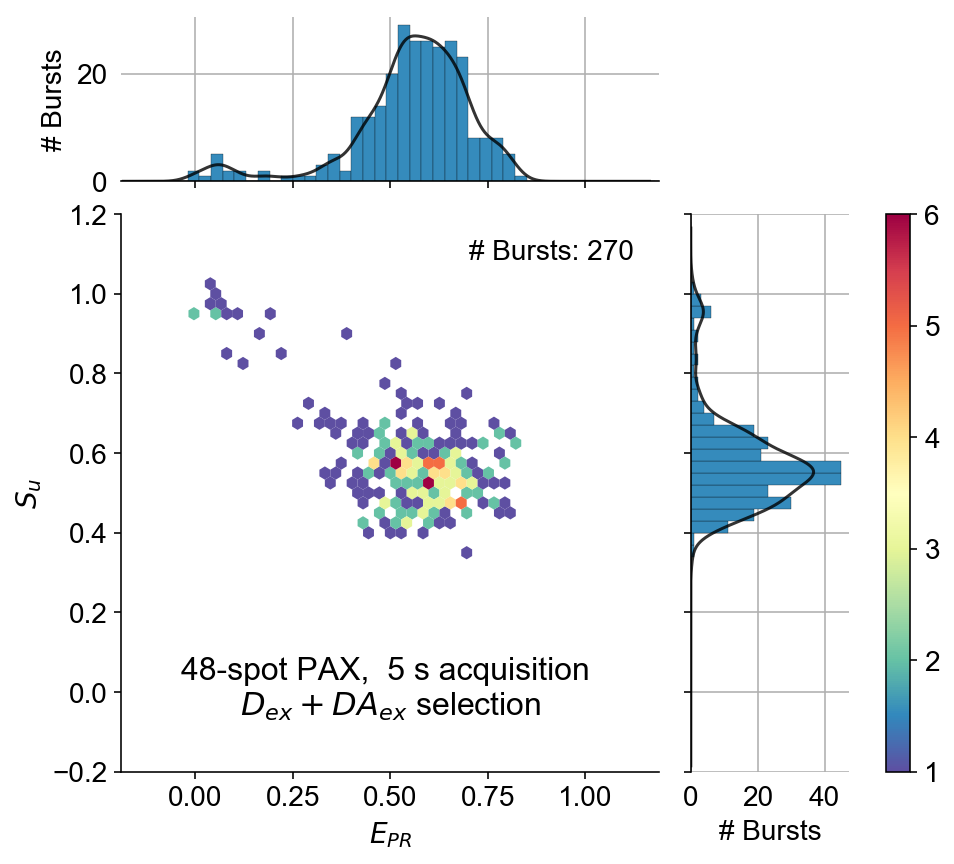

In [82]:
g = alex_jointplot(dcs5, S_name='Su')
g.ax_joint.set_ylabel('$S_u$');
g.ax_joint.set_xlabel('$E_{PR}$');
g.ax_joint.text(0.5, 0.1, '48-spot PAX,  5 s acquisition \n$D_{ex} + DA_{ex}$ selection', 
                ha='center', transform=g.ax_joint.transAxes,
                fontsize=16, weight='medium')
savefig('alex_jointplot_5s')

In [83]:
size_th_alex_pax = 20
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem'), gamma=gamma_pax,
                    na_comp=False, naa_comp=False, naa_aexonly=False)
dcsa = dc.select_bursts(select_bursts.size, th1=size_th_alex_pax, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcsa.nd, dcsa.na, dcsa.naa)]
dcsa.add(Su=Su)
pax_burst_rate = (dcsa.num_bursts / (dcsa.time_max - dcsa.time_min))
print("Acquisition duration: %.1f s" % (dcsa.time_max - dcsa.time_min))
print("Burst rate:           %.1f burst/sec" % pax_burst_rate)
Math(d._burst_sizes_pax_formula(**size_sel_kws))

Acquisition duration: 302.8 s
Burst rate:           220.2 burst/sec


<IPython.core.display.Math object>

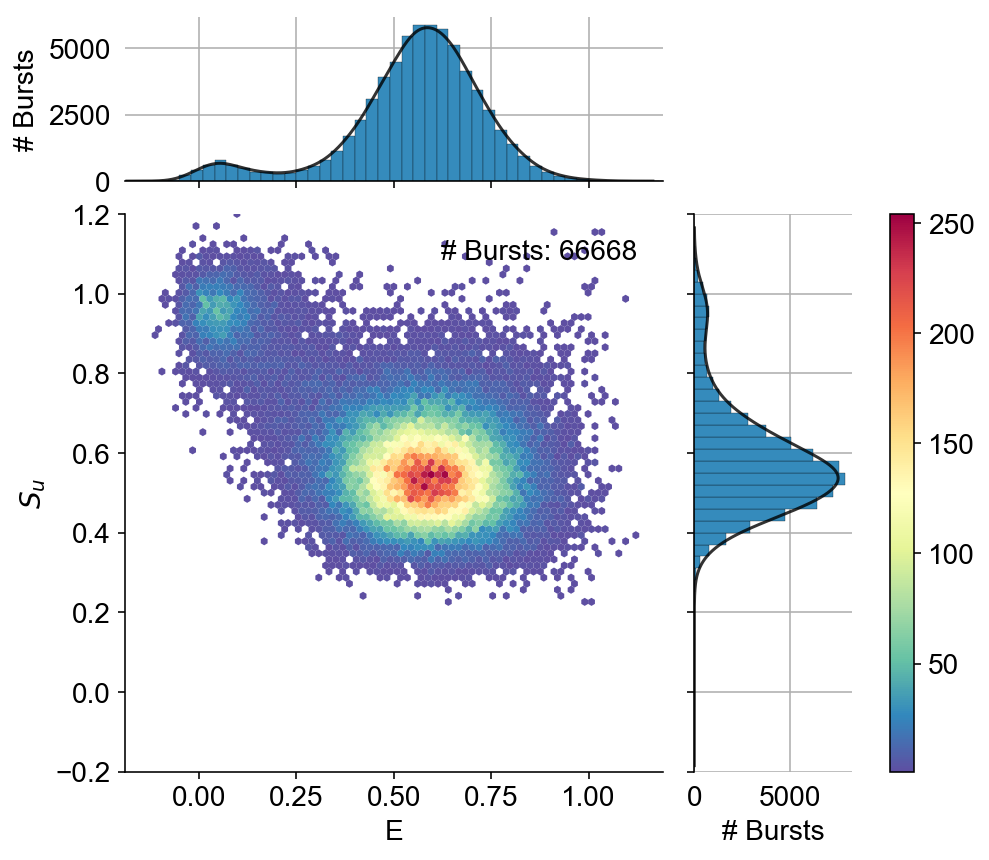

In [84]:
g = alex_jointplot(dcsa, S_name='Su', vmax_fret=True, gridsize=80)
g.ax_joint.set_ylabel('$S_u$');

In [85]:
dcsa5 = dcsa.select_bursts(select_bursts.time, time_s1=0, time_s2=5)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcsa5.nd, dcsa5.na, dcsa5.naa)]
dcsa5.add(Su=Su)

Saved: figures/2017-08-03_03_12d_alex_jointplot_5s_Dex.png
Saved hires: figures/2017-08-03_03_12d_alex_jointplot_5s_Dex_highres.png


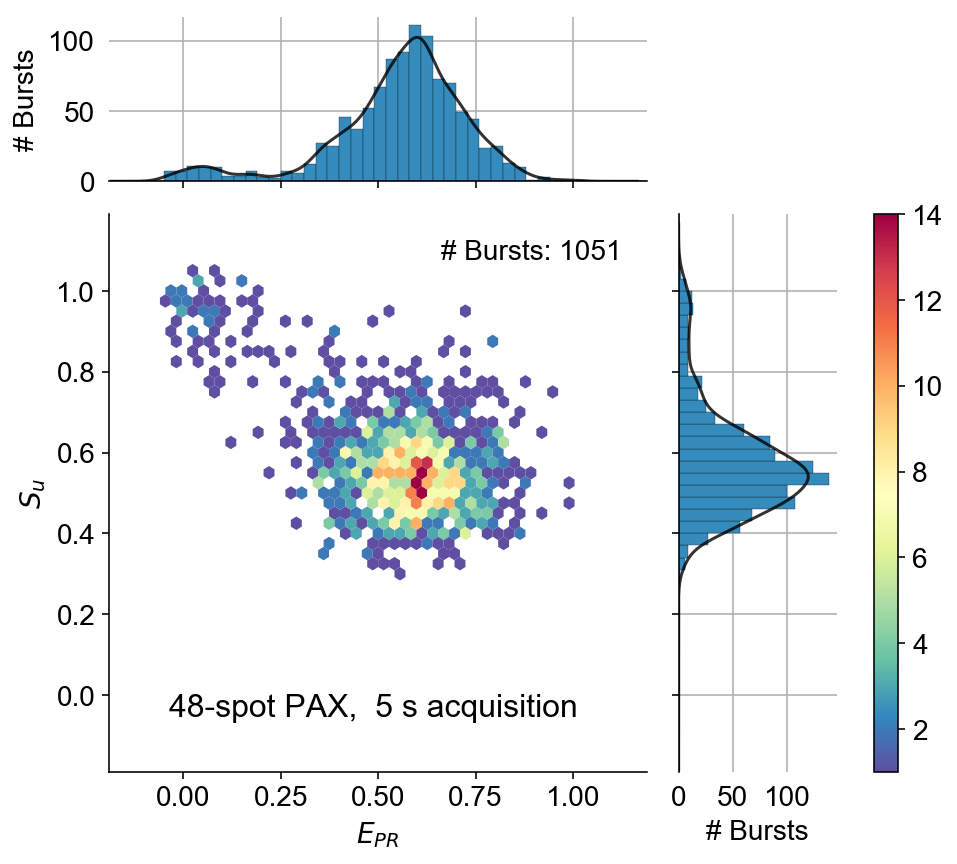

In [86]:
g = alex_jointplot(dcsa5, S_name='Su')
plt.setp(g.ax_joint, xlim=(-0.19, 1.19), ylim=(-0.19, 1.19))
g.ax_joint.set_ylabel('$S_u$');
g.ax_joint.set_xlabel('$E_{PR}$');
g.ax_joint.text(0.5, 0.1, '48-spot PAX,  5 s acquisition ', ha='center', transform=g.ax_joint.transAxes,
                fontsize=16, weight='medium')
savefig('alex_jointplot_5s_Dex')

# ALEX selection

In [87]:
daxs1 = dax.select_bursts(select_bursts.size, add_naa=False, th1=20)
daxss = daxs1.select_bursts(select_bursts.naa, th1=20)

In [88]:
E_pr_alex = np.median(daxss.E[0])
E_pr_alex

0.66087346173412453

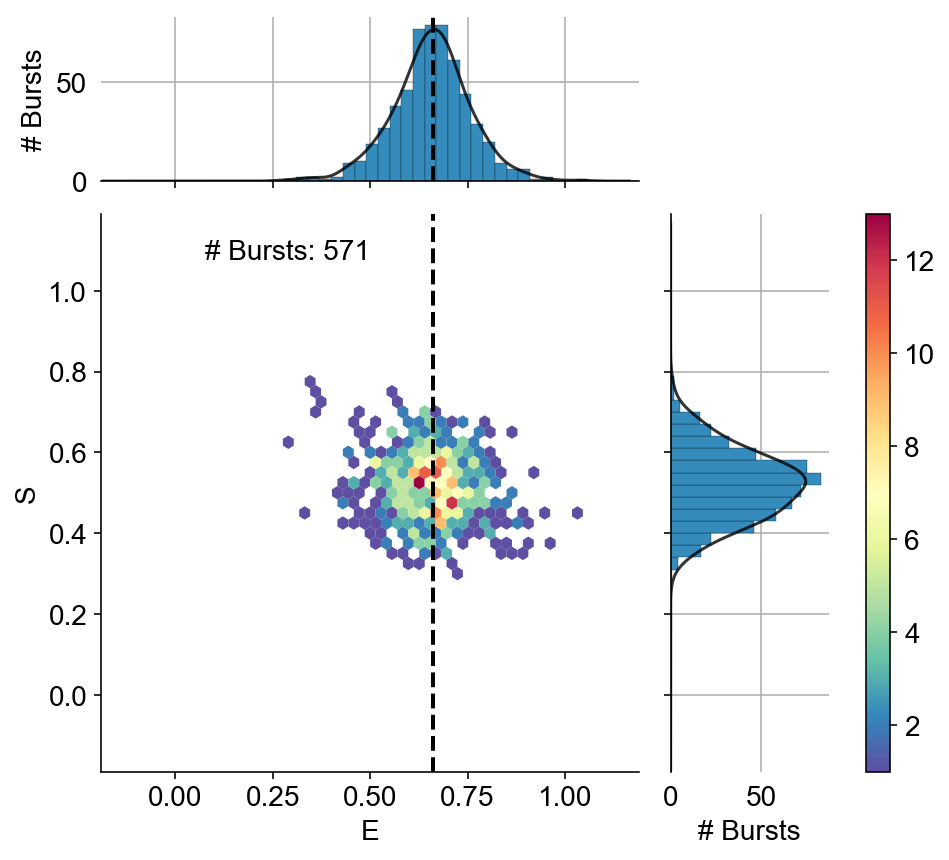

In [89]:
g = alex_jointplot(daxss)
g.ax_joint.axvline(E_pr_alex, lw=2, ls='--', color='k')
g.ax_marg_x.axvline(E_pr_alex, lw=2, ls='--', color='k');

$$\gamma = \frac{{E}^{-1} - 1}{{E_{PR}}^{-1} - 1}$$

In [90]:
gamma_alex = (1/E_calib - 1) / (1/E_pr_alex - 1)
gamma_alex

0.73178713801647832

### ALEX selection matching PAX selection

In [91]:
daxs = dax.select_bursts(select_bursts.size, add_naa=False, th1=size_th_alex_pax, gamma=gamma_alex)
alex_burst_rate = (daxs.num_bursts / (daxs.time_max - daxs.time_min))

Acquisition duration: 300.0 s
Burst rate:           5.9 burst/sec


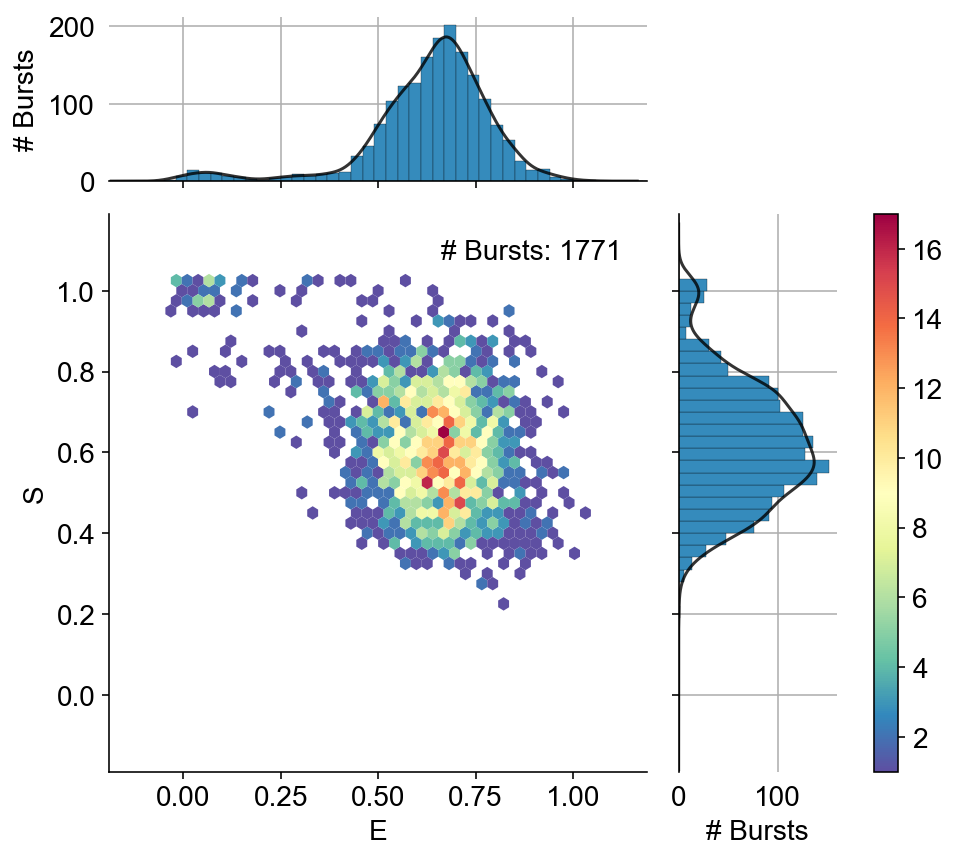

In [92]:
alex_jointplot(daxs, vmax_fret=False, vmin=1)
print("Acquisition duration: %.1f s" % (daxs.time_max - daxs.time_min))
print("Burst rate:           %.1f burst/sec" % alex_burst_rate)

In [93]:
daxs5 = daxs.select_bursts(select_bursts.time, time_s1=0, time_s2=5)

Saved: figures/2017-08-03_007_12d_alex_jointplot_5s_Dex.png
Saved hires: figures/2017-08-03_007_12d_alex_jointplot_5s_Dex_highres.png


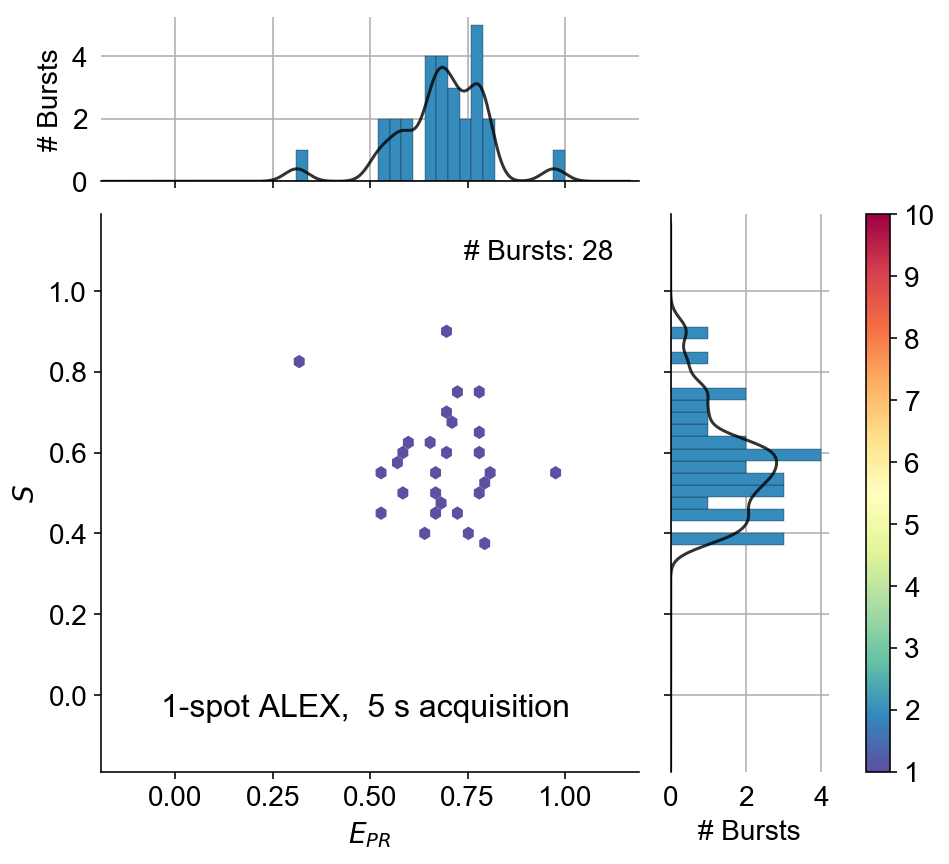

In [94]:
g = alex_jointplot(daxs5, vmax=10)
g.ax_joint.set_ylabel('$S$');
g.ax_joint.set_xlabel('$E_{PR}$');
g.ax_joint.text(0.5, 0.1, '1-spot ALEX,  5 s acquisition ', ha='center', transform=g.ax_joint.transAxes,
                fontsize=16, weight='medium')
savefig('alex_jointplot_5s_Dex', label=mlabel_alex)

In [95]:
print('Burst number ratio PAX/ALEX for 5s plots: %.1f' % (dcsa5.num_bursts/daxs5.num_bursts))

Burst number ratio PAX/ALEX for 5s plots: 37.5


# Rate comparison

## ALEX

In [96]:
bursts_alex = bext.burst_data(daxs, include_bg=True)

In [97]:
bursts_alex.head()

E         S     bg_aa     bg_ad     bg_da     bg_dd  bg_period  \
0  0.527397  0.438226  0.638477  0.566024  0.113901  0.650048          0   
1  0.703230  0.703474  0.456200  0.404432  0.081384  0.464468          0   
2  0.663668  0.626401  0.628758  0.557408  0.112167  0.640152          0   
3  0.667986  0.550796  0.983788  0.872150  0.175502  1.001617          0   
4  0.791857  0.388758  1.011762  0.896950  0.180493  1.030097          0   

       max_rate         na        naa         nd       nda         nt  \
0  14887.763409  10.433976  25.361523   9.349952 -0.113901  45.145451   
1  21324.940758  22.595568  13.543800   9.535532  0.918616  45.674900   
2  23027.375727  20.442592  18.371242  10.359848 -0.112167  49.173682   
3  18617.019897  22.127850  27.016212  10.998383 -0.175502  60.142445   
4           NaN  15.103050  29.988238   3.969903 -0.180493  49.061191   

   size_raw   t_start    t_stop  width_ms  spot  
0        47  0.100647  0.101948  1.301550     0  
1        48  0.368803  0.369733  0.929975     0  
2        51  0.372722  0.374004  1.281737     0  
3        63  0.625547  0.627552  2.005475     0  
4        52  0.630646  0.632708  2.062500     0

In [98]:
dlist_alex = bext.moving_window_chunks(daxs, daxs.time_min, daxs.time_max, step=5)

In [99]:
nburst_vs_t_alex = [d.num_bursts[0] for d in dlist_alex]

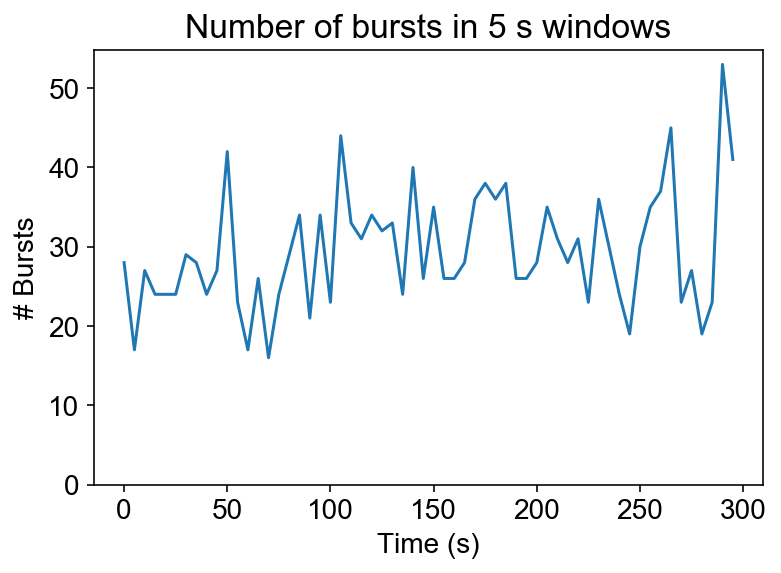

In [100]:
plt.plot(np.arange(len(nburst_vs_t_alex))*5, nburst_vs_t_alex)
plt.xlabel('Time (s)')
plt.ylabel('# Bursts')
plt.title('Number of bursts in 5 s windows')
plt.ylim(0);

In [101]:
# Exclude last window because it may be shorter
alex_burst_rate_5s = np.mean(nburst_vs_t_alex[:-1])/5
alex_burst_rate_5s_std = np.std(nburst_vs_t_alex[:-1])/5

## PAX

In [102]:
bursts = bext.burst_data(dcsa, include_bg=True)
bursts.tail()

E         S     bg_aa     bg_ad     bg_da     bg_dd  bg_period  \
66663  0.528329  0.713068  2.019793  0.982854  1.599345  1.426801         60   
66664  0.346268  0.869409  1.838965  0.894861  1.456159  1.299062         60   
66665  0.425232  0.887382  1.759452  0.856169  1.393198  1.242894         60   
66666  0.276725  0.691817  1.454877  0.707960  1.152025  1.027739         60   
66667  0.695662  0.935361  1.114105  0.542136  0.882189  0.787014         60   

              na        naa        nar         nd        nda         nt  \
66663   9.791834  17.249596   9.791834  11.860024   5.623485  44.524939   
66664  12.899999  18.495834  12.899999  22.962084  25.746722  80.104640   
66665   9.849314  12.788832   9.849314  10.919838  15.705977  49.263961   
66666   5.001501  13.052880   5.001501  18.145300   7.999513  44.199194   
66667  12.099573  13.301522  12.099573   6.341573   4.245073  35.987742   

       size_raw     t_start      t_stop  width_ms  spot  
66663        51  302.906385  302.908280  1.894375     0  
66664        86  302.909336  302.911061  1.724775     0  
66665        55  302.915985  302.917635  1.650200     0  
66666        53  302.916153  302.917517  1.364537     0  
66667        40  302.923338  302.924383  1.044925     0

In [103]:
val, nburst_vs_t = np.unique(bursts.bg_period, return_counts=True)

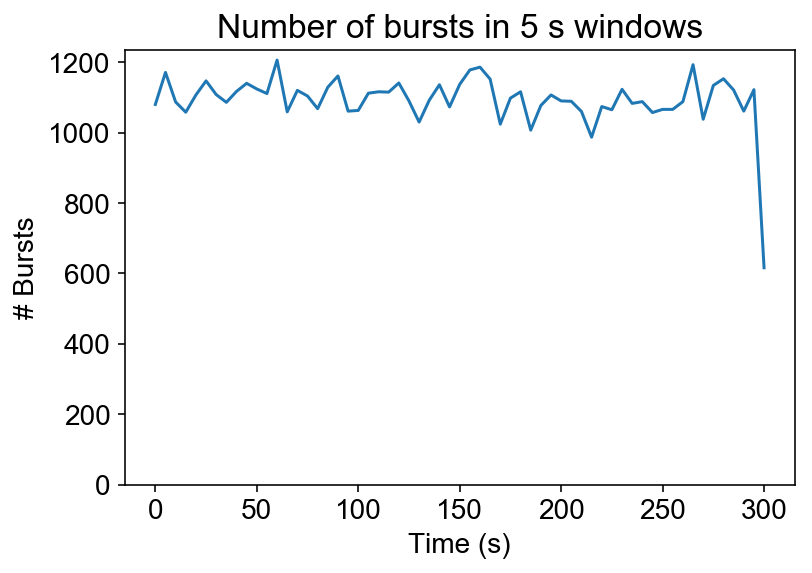

In [104]:
plt.plot(val*5, nburst_vs_t)
plt.xlabel('Time (s)')
plt.ylabel('# Bursts')
plt.title('Number of bursts in 5 s windows')
plt.ylim(0);

In [105]:
# Exclude last window because it may be shorter
pax_burst_rate_5s = np.mean(nburst_vs_t[:-1])/5
pax_burst_rate_5s_std = np.std(nburst_vs_t[:-1])/5

In [106]:
ratio_min = (pax_burst_rate - pax_burst_rate_5s_std)/(alex_burst_rate + alex_burst_rate_5s_std) 
ratio_max = (pax_burst_rate + pax_burst_rate_5s_std)/(alex_burst_rate - alex_burst_rate_5s_std)
ratio_min, ratio_max

(array([ 28.7415154]), array([ 51.41653694]))

In [107]:
ratios_5s = nburst_vs_t[:-2] / nburst_vs_t_alex[:-1]
ratios_5s.size

59

In [108]:
ratios_5s_range = ratios_5s.mean() - ratios_5s.std(), ratios_5s.mean() + ratios_5s.std()
ratios_5s_range

(29.289763374757126, 50.594211513801326)

In [109]:
print('The range (mean ± σ) for the burst rate ratio: (%.1f %.1f)' % (ratio_min, ratio_max))

The range (mean ± σ) for the burst rate ratio: (28.7 51.4)


In [110]:
print('The ratio of burst rate over 5 min. measurements: %.1f' % (pax_burst_rate/alex_burst_rate))

The ratio of burst rate over 5 min. measurements: 37.3


In [111]:
print('Burst number ratio PAX/ALEX in the 5s E-S plots: %.1f' % (dcsa5.num_bursts/daxs5.num_bursts))

Burst number ratio PAX/ALEX in the 5s E-S plots: 37.5


In [112]:
print('Standard deviation of # bursts ratio PAX/ALEX in 5s windows: %.1f' % ratios_5s.std())

Standard deviation of # bursts ratio PAX/ALEX in 5s windows: 10.7


In [113]:
print('Mean of # bursts ratio PAX/ALEX in 5s windows: %.1f' % ratios_5s.mean())

Mean of # bursts ratio PAX/ALEX in 5s windows: 39.9


In [114]:
print('The range (mean ± σ) for the burst rate ratio in 5s windows: (%.1f %.1f)' % ratios_5s_range)

The range (mean ± σ) for the burst rate ratio in 5s windows: (29.3 50.6)
